In [3]:
import torch
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.append(project_root)
    
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import MLFlowLogger
from model_utils import Model, ClassificationData

torch.set_float32_matmul_precision("medium")
print(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print("Using device:", torch.cuda.get_device_name(0))
print("VRAM:", round(torch.cuda.get_device_properties(0).total_memory / 1024 ** 3), "GB")

cuda
Using device: NVIDIA GeForce RTX 4060 Ti
VRAM: 8 GB


In [ ]:
hyperparams = {
   "learning_rate": [1e-1],
   "batch_size": [512],
    "dropout": [0.2, 0.3, 0.4],
   "weight_decay": [1e-1, 1e-2, 1e-3],
}
runs = 10
example_hyperparams = {
    "learning_rate": 1e-5,
    "batch_size": 128,
    "dropout": 0.4,
    "weight_decay": 1e-3,
}
# iterate over all hyperparameters
for lr in hyperparams["learning_rate"]:
    for bs in hyperparams["batch_size"]:
        for wd in hyperparams["weight_decay"]:
            for dp in hyperparams["dropout"]:
                example_hyperparams["learning_rate"] = lr
                example_hyperparams["batch_size"] = bs
                example_hyperparams["weight_decay"] = wd
                example_hyperparams["dropout"] = dp
                for i in range(runs):
                    seed = 123 + i
                    L.seed_everything(seed)
                    torch.cuda.empty_cache()
                    model = Model(example_hyperparams)
                    logger = MLFlowLogger(save_dir="mlruns", experiment_name="CNN")
                    early_stop = EarlyStopping(monitor="train_loss", patience=3, mode="min", verbose=True, min_delta=0.01)
                    checkpoint_callback = ModelCheckpoint(monitor="val_f1_macro", mode="max", dirpath="checkpoints/cnn", filename=f"run_{i}_lr={model.hyperparameters["learning_rate"]}_bs={model.hyperparameters["batch_size"]}_wd={model.hyperparameters["weight_decay"]}_dropout={model.hyperparameters["dropout"]}_seed={seed}" + "-{epoch:02d}-{val_f1_macro:.2f}")
                    trainer = L.Trainer(max_epochs=20, logger=logger, num_sanity_val_steps=0, enable_model_summary=False, deterministic=False, callbacks=[early_stop, checkpoint_callback], precision="16-mixed")
                    data = ClassificationData(batch_size=model.hyperparameters["batch_size"])
                    trainer.fit(model, datamodule=data)
                    trainer.test(model, datamodule=data)

In [ ]:
# for now best set of hyperparameters is lr=0.1, bs=512, wd=0.001, dropout=0.2
from lightning.pytorch.tuner.tuning import Tuner

best_hyperparams = {
    "learning_rate": 0.1,
    "batch_size": 512,
    "dropout": 0.2,
    "weight_decay": 0.001,
}

  
dummy_model = Model(best_hyperparams)        
dummy_trainer = L.Trainer(logger=False, precision="16-mixed", enable_checkpointing=False)
tuner = Tuner(dummy_trainer)
find_lr = tuner.lr_find(model=dummy_model, datamodule=ClassificationData(batch_size=dummy_model.hyperparameters["batch_size"]), min_lr=1e-8, max_lr=1, num_training=1000)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\SPCX\Desktop\github-repositories\dl-cnn\.venv\Lib\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 1000/1000 [01:31<00:00, 10.91it/s]
Learning rate set to 0.0014454397707459282
Restoring states from the checkpoint path at c:\Users\SPCX\Desktop\github-repositories\dl-cnn\model\.lr_find_3fd6a71b-cb94-41ee-ba08-c80ce0af0057.ckpt
Restored all states from the checkpoint at c:\Users\SPCX\Desktop\github-repositories\dl-cnn\model\.lr_find_3fd6a71b-cb94-41ee-ba08-c80ce0af0057.ckpt


Suggested lr: 0.0014454397707459282


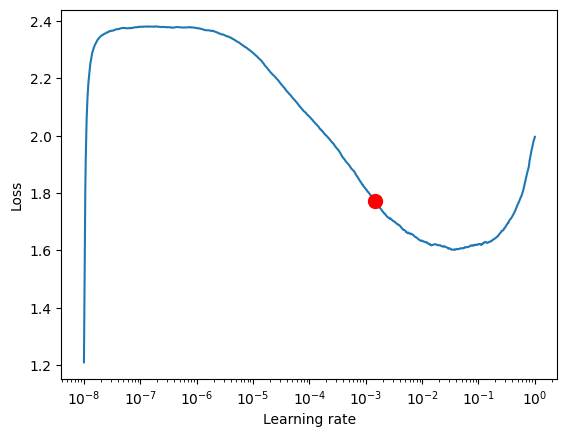

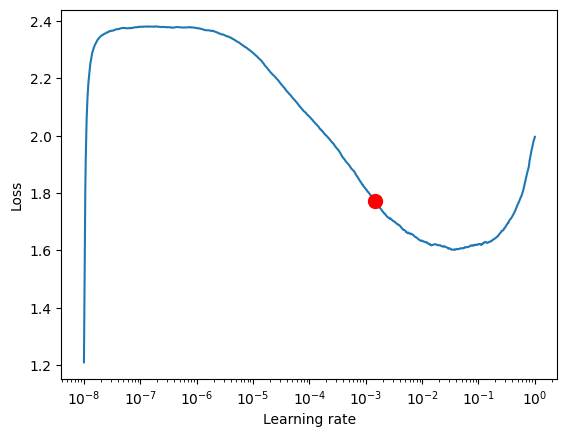

In [ ]:
print(f"Suggested lr: {find_lr.suggestion()}")
find_lr.plot(suggest=True)

In [10]:
hyperparams = {
    "learning_rate": find_lr.suggestion(),
    "batch_size": 512,
    "dropout": 0.2,
    "weight_decay": 0.001,
}
for i in range(10):
    seed = 123 + i
    L.seed_everything(seed)
    torch.cuda.empty_cache()
    model = Model(hyperparams)
    logger = MLFlowLogger(save_dir="mlruns", experiment_name="CNN")
    early_stop = EarlyStopping(monitor="train_loss", patience=3, mode="min", verbose=True, min_delta=0.01)
    checkpoint_callback = ModelCheckpoint(monitor="val_f1_macro", mode="max", dirpath="checkpoints/cnn", filename=f"run_{i}_lr={model.hyperparameters["learning_rate"]}_bs={model.hyperparameters["batch_size"]}_wd={model.hyperparameters["weight_decay"]}_dropout={model.hyperparameters["dropout"]}_seed={seed}" + "-{epoch:02d}-{val_f1_macro:.2f}")
    trainer = L.Trainer(max_epochs=20, logger=logger, num_sanity_val_steps=0, enable_model_summary=False, deterministic=False, callbacks=[early_stop, checkpoint_callback], precision="16-mixed")
    data = ClassificationData(batch_size=model.hyperparameters["batch_size"])
    trainer.fit(model, datamodule=data)
    trainer.test(model, datamodule=data)

Seed set to 123
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\SPCX\Desktop\github-repositories\dl-cnn\.venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\SPCX\Desktop\github-repositories\dl-cnn\model\checkpoints\cnn exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:32<00:00,  5.48it/s, v_num=bf2f]

Metric train_loss improved. New best score: 1.924


Epoch 1: 100%|██████████| 176/176 [00:14<00:00, 11.77it/s, v_num=bf2f]

Metric train_loss improved by 0.216 >= min_delta = 0.01. New best score: 1.708


Epoch 2: 100%|██████████| 176/176 [00:15<00:00, 11.30it/s, v_num=bf2f]

Metric train_loss improved by 0.091 >= min_delta = 0.01. New best score: 1.617


Epoch 3: 100%|██████████| 176/176 [00:15<00:00, 11.54it/s, v_num=bf2f]

Metric train_loss improved by 0.060 >= min_delta = 0.01. New best score: 1.557


Epoch 4: 100%|██████████| 176/176 [00:15<00:00, 11.52it/s, v_num=bf2f]

Metric train_loss improved by 0.039 >= min_delta = 0.01. New best score: 1.518


Epoch 5: 100%|██████████| 176/176 [00:15<00:00, 11.04it/s, v_num=bf2f]

Metric train_loss improved by 0.032 >= min_delta = 0.01. New best score: 1.485


Epoch 6: 100%|██████████| 176/176 [00:15<00:00, 11.36it/s, v_num=bf2f]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 1.465


Epoch 7: 100%|██████████| 176/176 [00:15<00:00, 11.37it/s, v_num=bf2f]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 1.445


Epoch 8: 100%|██████████| 176/176 [00:15<00:00, 11.64it/s, v_num=bf2f]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 1.427


Epoch 10: 100%|██████████| 176/176 [00:14<00:00, 11.80it/s, v_num=bf2f]

Metric train_loss improved by 0.025 >= min_delta = 0.01. New best score: 1.402


Epoch 11: 100%|██████████| 176/176 [00:15<00:00, 11.42it/s, v_num=bf2f]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 1.391


Epoch 13: 100%|██████████| 176/176 [00:15<00:00, 11.50it/s, v_num=bf2f]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 1.373


Epoch 15: 100%|██████████| 176/176 [00:15<00:00, 11.44it/s, v_num=bf2f]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.358


Epoch 17: 100%|██████████| 176/176 [00:15<00:00, 11.40it/s, v_num=bf2f]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 1.345


Epoch 18: 100%|██████████| 176/176 [00:15<00:00, 11.48it/s, v_num=bf2f]

Metric train_loss improved by 0.010 >= min_delta = 0.01. New best score: 1.335


Epoch 19: 100%|██████████| 176/176 [00:15<00:00, 11.57it/s, v_num=bf2f]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:15<00:00, 11.55it/s, v_num=bf2f]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\SPCX\Desktop\github-repositories\dl-cnn\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 176/176 [00:07<00:00, 23.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc            0.89691561460495
      test_f1_macro         0.5132434368133545
     test_precision         0.5223286151885986
       test_recall          0.5179555416107178
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 124
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:31<00:00,  5.63it/s, v_num=d334]

Metric train_loss improved. New best score: 1.915


Epoch 1: 100%|██████████| 176/176 [00:15<00:00, 11.68it/s, v_num=d334]

Metric train_loss improved by 0.209 >= min_delta = 0.01. New best score: 1.706


Epoch 2: 100%|██████████| 176/176 [00:15<00:00, 11.72it/s, v_num=d334]

Metric train_loss improved by 0.092 >= min_delta = 0.01. New best score: 1.615


Epoch 3: 100%|██████████| 176/176 [00:14<00:00, 11.76it/s, v_num=d334]

Metric train_loss improved by 0.059 >= min_delta = 0.01. New best score: 1.556


Epoch 4: 100%|██████████| 176/176 [00:15<00:00, 11.20it/s, v_num=d334]

Metric train_loss improved by 0.044 >= min_delta = 0.01. New best score: 1.512


Epoch 5: 100%|██████████| 176/176 [00:15<00:00, 11.15it/s, v_num=d334]

Metric train_loss improved by 0.031 >= min_delta = 0.01. New best score: 1.481


Epoch 6: 100%|██████████| 176/176 [00:15<00:00, 11.46it/s, v_num=d334]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 1.460


Epoch 7: 100%|██████████| 176/176 [00:15<00:00, 11.51it/s, v_num=d334]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 1.444


Epoch 8: 100%|██████████| 176/176 [00:15<00:00, 11.65it/s, v_num=d334]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 1.427


Epoch 9: 100%|██████████| 176/176 [00:14<00:00, 12.01it/s, v_num=d334]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 1.413


Epoch 10: 100%|██████████| 176/176 [00:14<00:00, 12.24it/s, v_num=d334]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 1.397


Epoch 12: 100%|██████████| 176/176 [00:15<00:00, 11.72it/s, v_num=d334]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 1.379


Epoch 14: 100%|██████████| 176/176 [00:14<00:00, 12.31it/s, v_num=d334]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 1.366


Epoch 15: 100%|██████████| 176/176 [00:14<00:00, 12.48it/s, v_num=d334]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 1.352


Epoch 17: 100%|██████████| 176/176 [00:14<00:00, 12.53it/s, v_num=d334]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 1.340


Epoch 19: 100%|██████████| 176/176 [00:14<00:00, 12.52it/s, v_num=d334]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:14<00:00, 12.49it/s, v_num=d334]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:07<00:00, 23.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.8987712860107422
      test_f1_macro         0.5151726007461548
     test_precision           0.521240234375
       test_recall           0.521755576133728
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 125
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:32<00:00,  5.46it/s, v_num=51d0]

Metric train_loss improved. New best score: 1.924


Epoch 1: 100%|██████████| 176/176 [00:14<00:00, 11.74it/s, v_num=51d0]

Metric train_loss improved by 0.216 >= min_delta = 0.01. New best score: 1.709


Epoch 2: 100%|██████████| 176/176 [00:15<00:00, 11.53it/s, v_num=51d0]

Metric train_loss improved by 0.096 >= min_delta = 0.01. New best score: 1.612


Epoch 3: 100%|██████████| 176/176 [00:15<00:00, 11.51it/s, v_num=51d0]

Metric train_loss improved by 0.060 >= min_delta = 0.01. New best score: 1.552


Epoch 4: 100%|██████████| 176/176 [00:15<00:00, 11.49it/s, v_num=51d0]

Metric train_loss improved by 0.038 >= min_delta = 0.01. New best score: 1.515


Epoch 5: 100%|██████████| 176/176 [00:15<00:00, 11.69it/s, v_num=51d0]

Metric train_loss improved by 0.030 >= min_delta = 0.01. New best score: 1.484


Epoch 6: 100%|██████████| 176/176 [00:15<00:00, 11.67it/s, v_num=51d0]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.462


Epoch 7: 100%|██████████| 176/176 [00:15<00:00, 11.42it/s, v_num=51d0]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.439


Epoch 8: 100%|██████████| 176/176 [00:15<00:00, 11.54it/s, v_num=51d0]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 1.420


Epoch 10: 100%|██████████| 176/176 [00:14<00:00, 11.76it/s, v_num=51d0]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 1.399


Epoch 12: 100%|██████████| 176/176 [00:15<00:00, 11.38it/s, v_num=51d0]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 1.379


Epoch 14: 100%|██████████| 176/176 [00:14<00:00, 11.79it/s, v_num=51d0]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 1.360


Epoch 16: 100%|██████████| 176/176 [00:15<00:00, 11.65it/s, v_num=51d0]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 1.348


Epoch 18: 100%|██████████| 176/176 [00:14<00:00, 11.88it/s, v_num=51d0]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 1.335


Epoch 19: 100%|██████████| 176/176 [00:15<00:00, 11.67it/s, v_num=51d0]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:15<00:00, 11.65it/s, v_num=51d0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:07<00:00, 24.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.8990101218223572
      test_f1_macro         0.5170510411262512
     test_precision         0.5195085406303406
       test_recall          0.5231000185012817
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 126
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:31<00:00,  5.61it/s, v_num=15c8]

Metric train_loss improved. New best score: 1.926


Epoch 1: 100%|██████████| 176/176 [00:15<00:00, 11.55it/s, v_num=15c8]

Metric train_loss improved by 0.216 >= min_delta = 0.01. New best score: 1.710


Epoch 2: 100%|██████████| 176/176 [00:14<00:00, 11.84it/s, v_num=15c8]

Metric train_loss improved by 0.096 >= min_delta = 0.01. New best score: 1.615


Epoch 3: 100%|██████████| 176/176 [00:15<00:00, 11.61it/s, v_num=15c8]

Metric train_loss improved by 0.060 >= min_delta = 0.01. New best score: 1.555


Epoch 4: 100%|██████████| 176/176 [00:14<00:00, 11.79it/s, v_num=15c8]

Metric train_loss improved by 0.040 >= min_delta = 0.01. New best score: 1.514


Epoch 5: 100%|██████████| 176/176 [00:15<00:00, 11.51it/s, v_num=15c8]

Metric train_loss improved by 0.033 >= min_delta = 0.01. New best score: 1.481


Epoch 6: 100%|██████████| 176/176 [00:15<00:00, 11.65it/s, v_num=15c8]

Metric train_loss improved by 0.026 >= min_delta = 0.01. New best score: 1.456


Epoch 7: 100%|██████████| 176/176 [00:14<00:00, 11.78it/s, v_num=15c8]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 1.436


Epoch 8: 100%|██████████| 176/176 [00:15<00:00, 11.45it/s, v_num=15c8]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.422


Epoch 9: 100%|██████████| 176/176 [00:15<00:00, 11.29it/s, v_num=15c8]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.408


Epoch 10: 100%|██████████| 176/176 [00:15<00:00, 11.35it/s, v_num=15c8]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 1.393


Epoch 12: 100%|██████████| 176/176 [00:15<00:00, 11.56it/s, v_num=15c8]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 1.374


Epoch 14: 100%|██████████| 176/176 [00:15<00:00, 11.27it/s, v_num=15c8]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 1.357


Epoch 16: 100%|██████████| 176/176 [00:15<00:00, 11.58it/s, v_num=15c8]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 1.345


Epoch 18: 100%|██████████| 176/176 [00:15<00:00, 11.37it/s, v_num=15c8]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 1.328


Epoch 19: 100%|██████████| 176/176 [00:15<00:00, 11.72it/s, v_num=15c8]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:15<00:00, 11.69it/s, v_num=15c8]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:06<00:00, 25.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9000608325004578
      test_f1_macro         0.5217176675796509
     test_precision         0.5241191983222961
       test_recall          0.5246777534484863
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 127
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:31<00:00,  5.55it/s, v_num=1320]

Metric train_loss improved. New best score: 1.915


Epoch 1: 100%|██████████| 176/176 [00:14<00:00, 11.89it/s, v_num=1320]

Metric train_loss improved by 0.211 >= min_delta = 0.01. New best score: 1.704


Epoch 2: 100%|██████████| 176/176 [00:14<00:00, 11.78it/s, v_num=1320]

Metric train_loss improved by 0.092 >= min_delta = 0.01. New best score: 1.612


Epoch 3: 100%|██████████| 176/176 [00:15<00:00, 11.63it/s, v_num=1320]

Metric train_loss improved by 0.058 >= min_delta = 0.01. New best score: 1.554


Epoch 4: 100%|██████████| 176/176 [00:14<00:00, 11.91it/s, v_num=1320]

Metric train_loss improved by 0.042 >= min_delta = 0.01. New best score: 1.512


Epoch 5: 100%|██████████| 176/176 [00:15<00:00, 11.65it/s, v_num=1320]

Metric train_loss improved by 0.032 >= min_delta = 0.01. New best score: 1.480


Epoch 6: 100%|██████████| 176/176 [00:14<00:00, 11.83it/s, v_num=1320]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 1.460


Epoch 7: 100%|██████████| 176/176 [00:15<00:00, 11.48it/s, v_num=1320]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 1.438


Epoch 8: 100%|██████████| 176/176 [00:14<00:00, 11.78it/s, v_num=1320]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 1.425


Epoch 9: 100%|██████████| 176/176 [00:15<00:00, 11.63it/s, v_num=1320]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 1.413


Epoch 10: 100%|██████████| 176/176 [00:14<00:00, 11.74it/s, v_num=1320]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 1.396


Epoch 11: 100%|██████████| 176/176 [00:15<00:00, 11.62it/s, v_num=1320]

Metric train_loss improved by 0.010 >= min_delta = 0.01. New best score: 1.386


Epoch 12: 100%|██████████| 176/176 [00:15<00:00, 11.52it/s, v_num=1320]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 1.374


Epoch 14: 100%|██████████| 176/176 [00:15<00:00, 11.65it/s, v_num=1320]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 1.362


Epoch 16: 100%|██████████| 176/176 [00:15<00:00, 11.48it/s, v_num=1320]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 1.346


Epoch 18: 100%|██████████| 176/176 [00:15<00:00, 11.47it/s, v_num=1320]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 1.334


Epoch 19: 100%|██████████| 176/176 [00:15<00:00, 11.40it/s, v_num=1320]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:15<00:00, 11.37it/s, v_num=1320]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:07<00:00, 24.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc            0.900007426738739
      test_f1_macro         0.5257073640823364
     test_precision         0.5275571346282959
       test_recall          0.5275111198425293
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 128
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:31<00:00,  5.56it/s, v_num=2fa4]

Metric train_loss improved. New best score: 1.927


Epoch 1: 100%|██████████| 176/176 [00:15<00:00, 11.43it/s, v_num=2fa4]

Metric train_loss improved by 0.229 >= min_delta = 0.01. New best score: 1.698


Epoch 2: 100%|██████████| 176/176 [00:15<00:00, 11.59it/s, v_num=2fa4]

Metric train_loss improved by 0.099 >= min_delta = 0.01. New best score: 1.599


Epoch 3: 100%|██████████| 176/176 [00:15<00:00, 11.25it/s, v_num=2fa4]

Metric train_loss improved by 0.055 >= min_delta = 0.01. New best score: 1.544


Epoch 4: 100%|██████████| 176/176 [00:15<00:00, 11.61it/s, v_num=2fa4]

Metric train_loss improved by 0.042 >= min_delta = 0.01. New best score: 1.502


Epoch 5: 100%|██████████| 176/176 [00:15<00:00, 11.64it/s, v_num=2fa4]

Metric train_loss improved by 0.028 >= min_delta = 0.01. New best score: 1.474


Epoch 6: 100%|██████████| 176/176 [00:15<00:00, 11.60it/s, v_num=2fa4]

Metric train_loss improved by 0.025 >= min_delta = 0.01. New best score: 1.449


Epoch 7: 100%|██████████| 176/176 [00:14<00:00, 11.92it/s, v_num=2fa4]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 1.433


Epoch 8: 100%|██████████| 176/176 [00:14<00:00, 11.78it/s, v_num=2fa4]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.419


Epoch 9: 100%|██████████| 176/176 [00:15<00:00, 11.69it/s, v_num=2fa4]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.405


Epoch 10: 100%|██████████| 176/176 [00:15<00:00, 11.63it/s, v_num=2fa4]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 1.393


Epoch 11: 100%|██████████| 176/176 [00:15<00:00, 11.67it/s, v_num=2fa4]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 1.382


Epoch 13: 100%|██████████| 176/176 [00:14<00:00, 11.80it/s, v_num=2fa4]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 1.367


Epoch 14: 100%|██████████| 176/176 [00:15<00:00, 11.37it/s, v_num=2fa4]

Metric train_loss improved by 0.010 >= min_delta = 0.01. New best score: 1.357


Epoch 16: 100%|██████████| 176/176 [00:15<00:00, 11.69it/s, v_num=2fa4]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 1.344


Epoch 18: 100%|██████████| 176/176 [00:15<00:00, 11.52it/s, v_num=2fa4]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 1.331


Epoch 19: 100%|██████████| 176/176 [00:15<00:00, 11.62it/s, v_num=2fa4]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:15<00:00, 11.59it/s, v_num=2fa4]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:06<00:00, 25.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9004284143447876
      test_f1_macro         0.5289610624313354
     test_precision         0.5310745239257812
       test_recall          0.5301222205162048
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 129
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:32<00:00,  5.48it/s, v_num=6ffb]

Metric train_loss improved. New best score: 1.928


Epoch 1: 100%|██████████| 176/176 [00:15<00:00, 11.45it/s, v_num=6ffb]

Metric train_loss improved by 0.216 >= min_delta = 0.01. New best score: 1.711


Epoch 2: 100%|██████████| 176/176 [00:15<00:00, 11.73it/s, v_num=6ffb]

Metric train_loss improved by 0.093 >= min_delta = 0.01. New best score: 1.618


Epoch 3: 100%|██████████| 176/176 [00:15<00:00, 11.39it/s, v_num=6ffb]

Metric train_loss improved by 0.057 >= min_delta = 0.01. New best score: 1.561


Epoch 4: 100%|██████████| 176/176 [00:15<00:00, 11.57it/s, v_num=6ffb]

Metric train_loss improved by 0.042 >= min_delta = 0.01. New best score: 1.519


Epoch 5: 100%|██████████| 176/176 [00:15<00:00, 11.50it/s, v_num=6ffb]

Metric train_loss improved by 0.028 >= min_delta = 0.01. New best score: 1.491


Epoch 6: 100%|██████████| 176/176 [00:15<00:00, 11.67it/s, v_num=6ffb]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.468


Epoch 7: 100%|██████████| 176/176 [00:15<00:00, 11.42it/s, v_num=6ffb]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 1.449


Epoch 8: 100%|██████████| 176/176 [00:15<00:00, 11.61it/s, v_num=6ffb]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 1.434


Epoch 9: 100%|██████████| 176/176 [00:14<00:00, 11.75it/s, v_num=6ffb]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 1.419


Epoch 10: 100%|██████████| 176/176 [00:15<00:00, 11.65it/s, v_num=6ffb]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 1.407


Epoch 11: 100%|██████████| 176/176 [00:15<00:00, 11.63it/s, v_num=6ffb]

Metric train_loss improved by 0.010 >= min_delta = 0.01. New best score: 1.397


Epoch 13: 100%|██████████| 176/176 [00:14<00:00, 11.78it/s, v_num=6ffb]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 1.380


Epoch 15: 100%|██████████| 176/176 [00:14<00:00, 11.94it/s, v_num=6ffb]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 1.363


Epoch 17: 100%|██████████| 176/176 [00:14<00:00, 11.80it/s, v_num=6ffb]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.349


Epoch 19: 100%|██████████| 176/176 [00:14<00:00, 11.92it/s, v_num=6ffb]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.335
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:14<00:00, 11.90it/s, v_num=6ffb]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:06<00:00, 25.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.8984991312026978
      test_f1_macro         0.5168823599815369
     test_precision         0.5179018974304199
       test_recall          0.5231778025627136
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 130
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:31<00:00,  5.57it/s, v_num=1738]

Metric train_loss improved. New best score: 1.929


Epoch 1: 100%|██████████| 176/176 [00:15<00:00, 11.60it/s, v_num=1738]

Metric train_loss improved by 0.215 >= min_delta = 0.01. New best score: 1.715


Epoch 2: 100%|██████████| 176/176 [00:15<00:00, 11.55it/s, v_num=1738]

Metric train_loss improved by 0.101 >= min_delta = 0.01. New best score: 1.614


Epoch 3: 100%|██████████| 176/176 [00:15<00:00, 11.54it/s, v_num=1738]

Metric train_loss improved by 0.058 >= min_delta = 0.01. New best score: 1.556


Epoch 4: 100%|██████████| 176/176 [00:15<00:00, 11.57it/s, v_num=1738]

Metric train_loss improved by 0.040 >= min_delta = 0.01. New best score: 1.515


Epoch 5: 100%|██████████| 176/176 [00:15<00:00, 11.65it/s, v_num=1738]

Metric train_loss improved by 0.030 >= min_delta = 0.01. New best score: 1.486


Epoch 6: 100%|██████████| 176/176 [00:15<00:00, 11.40it/s, v_num=1738]

Metric train_loss improved by 0.024 >= min_delta = 0.01. New best score: 1.462


Epoch 7: 100%|██████████| 176/176 [00:15<00:00, 11.55it/s, v_num=1738]

Metric train_loss improved by 0.024 >= min_delta = 0.01. New best score: 1.438


Epoch 8: 100%|██████████| 176/176 [00:15<00:00, 11.73it/s, v_num=1738]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 1.426


Epoch 9: 100%|██████████| 176/176 [00:15<00:00, 11.44it/s, v_num=1738]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.412


Epoch 10: 100%|██████████| 176/176 [00:15<00:00, 11.62it/s, v_num=1738]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 1.400


Epoch 11: 100%|██████████| 176/176 [00:15<00:00, 11.52it/s, v_num=1738]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 1.387


Epoch 13: 100%|██████████| 176/176 [00:15<00:00, 11.58it/s, v_num=1738]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 1.371


Epoch 15: 100%|██████████| 176/176 [00:15<00:00, 11.46it/s, v_num=1738]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.357


Epoch 17: 100%|██████████| 176/176 [00:15<00:00, 11.57it/s, v_num=1738]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 1.342


Epoch 19: 100%|██████████| 176/176 [00:15<00:00, 11.55it/s, v_num=1738]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 1.327
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:15<00:00, 11.53it/s, v_num=1738]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:06<00:00, 25.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.8973528742790222
      test_f1_macro         0.5198546051979065
     test_precision         0.5238113403320312
       test_recall          0.5223110914230347
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 131
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:31<00:00,  5.60it/s, v_num=0a40]

Metric train_loss improved. New best score: 1.908


Epoch 1: 100%|██████████| 176/176 [00:14<00:00, 11.75it/s, v_num=0a40]

Metric train_loss improved by 0.200 >= min_delta = 0.01. New best score: 1.708


Epoch 2: 100%|██████████| 176/176 [00:15<00:00, 11.67it/s, v_num=0a40]

Metric train_loss improved by 0.089 >= min_delta = 0.01. New best score: 1.619


Epoch 3: 100%|██████████| 176/176 [00:15<00:00, 11.64it/s, v_num=0a40]

Metric train_loss improved by 0.060 >= min_delta = 0.01. New best score: 1.559


Epoch 4: 100%|██████████| 176/176 [00:15<00:00, 11.60it/s, v_num=0a40]

Metric train_loss improved by 0.043 >= min_delta = 0.01. New best score: 1.517


Epoch 5: 100%|██████████| 176/176 [00:14<00:00, 11.82it/s, v_num=0a40]

Metric train_loss improved by 0.034 >= min_delta = 0.01. New best score: 1.483


Epoch 6: 100%|██████████| 176/176 [00:15<00:00, 11.58it/s, v_num=0a40]

Metric train_loss improved by 0.027 >= min_delta = 0.01. New best score: 1.455


Epoch 7: 100%|██████████| 176/176 [00:15<00:00, 11.72it/s, v_num=0a40]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 1.437


Epoch 8: 100%|██████████| 176/176 [00:15<00:00, 11.61it/s, v_num=0a40]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 1.420


Epoch 9: 100%|██████████| 176/176 [00:14<00:00, 11.80it/s, v_num=0a40]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 1.405


Epoch 11: 100%|██████████| 176/176 [00:15<00:00, 11.69it/s, v_num=0a40]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 1.385


Epoch 12: 100%|██████████| 176/176 [00:15<00:00, 11.40it/s, v_num=0a40]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 1.374


Epoch 14: 100%|██████████| 176/176 [00:15<00:00, 11.44it/s, v_num=0a40]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 1.359


Epoch 15: 100%|██████████| 176/176 [00:15<00:00, 11.53it/s, v_num=0a40]

Metric train_loss improved by 0.010 >= min_delta = 0.01. New best score: 1.348


Epoch 17: 100%|██████████| 176/176 [00:15<00:00, 11.52it/s, v_num=0a40]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 1.334


Epoch 19: 100%|██████████| 176/176 [00:15<00:00, 11.53it/s, v_num=0a40]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:15<00:00, 11.51it/s, v_num=0a40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:07<00:00, 24.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.8982226252555847
      test_f1_macro         0.5178290009498596
     test_precision         0.5170334577560425
       test_recall          0.5236555337905884
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 132
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:31<00:00,  5.58it/s, v_num=e36c]

Metric train_loss improved. New best score: 1.937


Epoch 1: 100%|██████████| 176/176 [00:15<00:00, 11.43it/s, v_num=e36c]

Metric train_loss improved by 0.221 >= min_delta = 0.01. New best score: 1.716


Epoch 2: 100%|██████████| 176/176 [00:15<00:00, 11.60it/s, v_num=e36c]

Metric train_loss improved by 0.095 >= min_delta = 0.01. New best score: 1.621


Epoch 3: 100%|██████████| 176/176 [00:15<00:00, 11.61it/s, v_num=e36c]

Metric train_loss improved by 0.064 >= min_delta = 0.01. New best score: 1.557


Epoch 4: 100%|██████████| 176/176 [00:15<00:00, 11.69it/s, v_num=e36c]

Metric train_loss improved by 0.043 >= min_delta = 0.01. New best score: 1.514


Epoch 5: 100%|██████████| 176/176 [00:15<00:00, 11.43it/s, v_num=e36c]

Metric train_loss improved by 0.032 >= min_delta = 0.01. New best score: 1.482


Epoch 6: 100%|██████████| 176/176 [00:14<00:00, 11.82it/s, v_num=e36c]

Metric train_loss improved by 0.024 >= min_delta = 0.01. New best score: 1.458


Epoch 7: 100%|██████████| 176/176 [00:14<00:00, 11.78it/s, v_num=e36c]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 1.440


Epoch 8: 100%|██████████| 176/176 [00:14<00:00, 11.85it/s, v_num=e36c]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 1.425


Epoch 9: 100%|██████████| 176/176 [00:15<00:00, 11.36it/s, v_num=e36c]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 1.410


Epoch 10: 100%|██████████| 176/176 [00:16<00:00, 10.98it/s, v_num=e36c]

Metric train_loss improved by 0.010 >= min_delta = 0.01. New best score: 1.400


Epoch 11: 100%|██████████| 176/176 [00:15<00:00, 11.55it/s, v_num=e36c]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 1.389


Epoch 13: 100%|██████████| 176/176 [00:15<00:00, 11.06it/s, v_num=e36c]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 1.370


Epoch 15: 100%|██████████| 176/176 [00:15<00:00, 11.57it/s, v_num=e36c]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.356


Epoch 17: 100%|██████████| 176/176 [00:15<00:00, 11.59it/s, v_num=e36c]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 1.345


Epoch 19: 100%|██████████| 176/176 [00:15<00:00, 11.46it/s, v_num=e36c]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 1.330
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:15<00:00, 11.44it/s, v_num=e36c]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:07<00:00, 24.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.8981388211250305
      test_f1_macro         0.5191931128501892
     test_precision         0.5201866030693054
       test_recall          0.5212000012397766
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [11]:
# load checkpoint and train it more
model = Model(hyperparams)
trainer = L.Trainer(max_epochs=50, logger=logger, num_sanity_val_steps=0, enable_model_summary=False, deterministic=False, precision="16-mixed", callbacks=[early_stop, checkpoint_callback])
checkpoint_path = "C:/Users/SPCX/Desktop/github-repositories/dl-cnn/model/checkpoints/cnn/run_3_lr=0.0014454397707459282_bs=512_wd=0.001_dropout=0.2_seed=126-epoch=19-val_f1_macro=0.52.ckpt"
trainer.fit(model, datamodule=data, ckpt_path=checkpoint_path)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\SPCX\Desktop\github-repositories\dl-cnn\.venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\SPCX\Desktop\github-repositories\dl-cnn\model\checkpoints\cnn exists and is not empty.
Restoring states from the checkpoint path at C:/Users/SPCX/Desktop/github-repositories/dl-cnn/model/checkpoints/cnn/run_3_lr=0.0014454397707459282_bs=512_wd=0.001_dropout=0.2_seed=126-epoch=19-val_f1_macro=0.52.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restored all states from the checkpoint at C:/Users/SPCX/Desktop/github-repositories/dl-cnn/model/checkpoints/cnn/run_3_lr=0.0014454397707459282_bs=512_wd=0.001_dropout=0.2_seed=126-epoch=19-val_f1_macro=0.52.ckpt


Epoch 21: 100%|██████████| 176/176 [00:14<00:00, 11.86it/s, v_num=e36c]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 1.316


Epoch 23: 100%|██████████| 176/176 [00:15<00:00, 11.45it/s, v_num=e36c]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.301


Epoch 26: 100%|██████████| 176/176 [00:15<00:00, 11.14it/s, v_num=e36c]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 1.290


Epoch 28: 100%|██████████| 176/176 [00:15<00:00, 11.56it/s, v_num=e36c]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 1.279


Epoch 31: 100%|██████████| 176/176 [00:16<00:00, 10.80it/s, v_num=e36c]

Metric train_loss improved by 0.010 >= min_delta = 0.01. New best score: 1.268


Epoch 34: 100%|██████████| 176/176 [00:14<00:00, 12.28it/s, v_num=e36c]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 1.257


Epoch 37: 100%|██████████| 176/176 [00:14<00:00, 12.30it/s, v_num=e36c]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 1.245


Epoch 40: 100%|██████████| 176/176 [00:14<00:00, 12.12it/s, v_num=e36c]

Monitored metric train_loss did not improve in the last 3 records. Best score: 1.245. Signaling Trainer to stop.


Epoch 40: 100%|██████████| 176/176 [00:14<00:00, 12.09it/s, v_num=e36c]


In [12]:
trainer.test(model, datamodule=data)
None

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\SPCX\Desktop\github-repositories\dl-cnn\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 176/176 [00:06<00:00, 25.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9107349514961243
      test_f1_macro          0.55082106590271
     test_precision         0.5577150583267212
       test_recall          0.5521667003631592
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Without Data Augmentation

In [13]:
from model_utils import no_augmentation
best_hyperparams = {
    "learning_rate": 0.1,
    "batch_size": 512,
    "dropout": 0.2,
    "weight_decay": 0.001,
}

for i in range(10):
    seed = 123 + i
    L.seed_everything(seed)
    torch.cuda.empty_cache()
    model = Model(best_hyperparams)
    logger = MLFlowLogger(save_dir="mlruns", experiment_name="CNN-no-augmentation")
    early_stop = EarlyStopping(monitor="train_loss", patience=3, mode="min", verbose=True, min_delta=0.01)
    checkpoint_callback = ModelCheckpoint(monitor="val_f1_macro", mode="max", dirpath="checkpoints/cnn", filename=f"no-augment_run_{i}_lr={model.hyperparameters["learning_rate"]}_bs={model.hyperparameters["batch_size"]}_wd={model.hyperparameters["weight_decay"]}_dropout={model.hyperparameters["dropout"]}_seed={seed}" + "-{epoch:02d}-{val_f1_macro:.2f}")
    trainer = L.Trainer(max_epochs=20, logger=logger, num_sanity_val_steps=0, enable_model_summary=False, deterministic=False, callbacks=[early_stop, checkpoint_callback], precision="16-mixed")
    data = ClassificationData(batch_size=model.hyperparameters["batch_size"], transform=no_augmentation)
    
    trainer.fit(model, datamodule=data)
    trainer.test(model, datamodule=data)

Seed set to 123
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Experiment with name CNN-no-augmentation not found. Creating it.
c:\Users\SPCX\Desktop\github-repositories\dl-cnn\.venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\SPCX\Desktop\github-repositories\dl-cnn\model\checkpoints\cnn exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:23<00:00,  7.54it/s, v_num=0681]

Metric train_loss improved. New best score: 1.466


Epoch 1: 100%|██████████| 176/176 [00:06<00:00, 25.98it/s, v_num=0681]

Metric train_loss improved by 0.226 >= min_delta = 0.01. New best score: 1.240


Epoch 2: 100%|██████████| 176/176 [00:06<00:00, 26.28it/s, v_num=0681]

Metric train_loss improved by 0.100 >= min_delta = 0.01. New best score: 1.140


Epoch 3: 100%|██████████| 176/176 [00:07<00:00, 23.34it/s, v_num=0681]

Metric train_loss improved by 0.065 >= min_delta = 0.01. New best score: 1.075


Epoch 4: 100%|██████████| 176/176 [00:06<00:00, 26.29it/s, v_num=0681]

Metric train_loss improved by 0.057 >= min_delta = 0.01. New best score: 1.018


Epoch 5: 100%|██████████| 176/176 [00:06<00:00, 26.21it/s, v_num=0681]

Metric train_loss improved by 0.052 >= min_delta = 0.01. New best score: 0.967


Epoch 6: 100%|██████████| 176/176 [00:06<00:00, 25.93it/s, v_num=0681]

Metric train_loss improved by 0.034 >= min_delta = 0.01. New best score: 0.932


Epoch 7: 100%|██████████| 176/176 [00:06<00:00, 26.08it/s, v_num=0681]

Metric train_loss improved by 0.043 >= min_delta = 0.01. New best score: 0.889


Epoch 8: 100%|██████████| 176/176 [00:06<00:00, 26.29it/s, v_num=0681]

Metric train_loss improved by 0.036 >= min_delta = 0.01. New best score: 0.853


Epoch 9: 100%|██████████| 176/176 [00:06<00:00, 26.15it/s, v_num=0681]

Metric train_loss improved by 0.037 >= min_delta = 0.01. New best score: 0.816


Epoch 10: 100%|██████████| 176/176 [00:06<00:00, 26.06it/s, v_num=0681]

Metric train_loss improved by 0.031 >= min_delta = 0.01. New best score: 0.785


Epoch 11: 100%|██████████| 176/176 [00:06<00:00, 26.29it/s, v_num=0681]

Metric train_loss improved by 0.024 >= min_delta = 0.01. New best score: 0.761


Epoch 12: 100%|██████████| 176/176 [00:06<00:00, 26.05it/s, v_num=0681]

Metric train_loss improved by 0.024 >= min_delta = 0.01. New best score: 0.738


Epoch 13: 100%|██████████| 176/176 [00:06<00:00, 26.20it/s, v_num=0681]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.717


Epoch 14: 100%|██████████| 176/176 [00:06<00:00, 26.22it/s, v_num=0681]

Metric train_loss improved by 0.024 >= min_delta = 0.01. New best score: 0.693


Epoch 15: 100%|██████████| 176/176 [00:06<00:00, 25.68it/s, v_num=0681]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.675


Epoch 16: 100%|██████████| 176/176 [00:06<00:00, 25.89it/s, v_num=0681]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.658


Epoch 17: 100%|██████████| 176/176 [00:06<00:00, 26.11it/s, v_num=0681]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.639


Epoch 18: 100%|██████████| 176/176 [00:06<00:00, 26.21it/s, v_num=0681]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.625


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 26.16it/s, v_num=0681]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.614
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 26.09it/s, v_num=0681]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\SPCX\Desktop\github-repositories\dl-cnn\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 176/176 [00:03<00:00, 55.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9140974283218384
      test_f1_macro         0.5728607177734375
     test_precision         0.5839903354644775
       test_recall          0.5725222229957581
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 124
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:23<00:00,  7.60it/s, v_num=e7f0]

Metric train_loss improved. New best score: 1.461


Epoch 1: 100%|██████████| 176/176 [00:06<00:00, 26.13it/s, v_num=e7f0]

Metric train_loss improved by 0.231 >= min_delta = 0.01. New best score: 1.229


Epoch 2: 100%|██████████| 176/176 [00:06<00:00, 26.25it/s, v_num=e7f0]

Metric train_loss improved by 0.098 >= min_delta = 0.01. New best score: 1.131


Epoch 3: 100%|██████████| 176/176 [00:06<00:00, 26.10it/s, v_num=e7f0]

Metric train_loss improved by 0.071 >= min_delta = 0.01. New best score: 1.060


Epoch 4: 100%|██████████| 176/176 [00:06<00:00, 26.23it/s, v_num=e7f0]

Metric train_loss improved by 0.051 >= min_delta = 0.01. New best score: 1.009


Epoch 5: 100%|██████████| 176/176 [00:06<00:00, 26.35it/s, v_num=e7f0]

Metric train_loss improved by 0.049 >= min_delta = 0.01. New best score: 0.960


Epoch 6: 100%|██████████| 176/176 [00:06<00:00, 25.95it/s, v_num=e7f0]

Metric train_loss improved by 0.039 >= min_delta = 0.01. New best score: 0.921


Epoch 7: 100%|██████████| 176/176 [00:06<00:00, 26.34it/s, v_num=e7f0]

Metric train_loss improved by 0.047 >= min_delta = 0.01. New best score: 0.874


Epoch 8: 100%|██████████| 176/176 [00:06<00:00, 26.32it/s, v_num=e7f0]

Metric train_loss improved by 0.032 >= min_delta = 0.01. New best score: 0.842


Epoch 9: 100%|██████████| 176/176 [00:06<00:00, 26.40it/s, v_num=e7f0]

Metric train_loss improved by 0.033 >= min_delta = 0.01. New best score: 0.809


Epoch 10: 100%|██████████| 176/176 [00:06<00:00, 26.42it/s, v_num=e7f0]

Metric train_loss improved by 0.035 >= min_delta = 0.01. New best score: 0.774


Epoch 11: 100%|██████████| 176/176 [00:06<00:00, 26.35it/s, v_num=e7f0]

Metric train_loss improved by 0.026 >= min_delta = 0.01. New best score: 0.748


Epoch 12: 100%|██████████| 176/176 [00:06<00:00, 26.25it/s, v_num=e7f0]

Metric train_loss improved by 0.029 >= min_delta = 0.01. New best score: 0.719


Epoch 13: 100%|██████████| 176/176 [00:06<00:00, 26.52it/s, v_num=e7f0]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.702


Epoch 14: 100%|██████████| 176/176 [00:06<00:00, 26.28it/s, v_num=e7f0]

Metric train_loss improved by 0.026 >= min_delta = 0.01. New best score: 0.677


Epoch 15: 100%|██████████| 176/176 [00:06<00:00, 25.94it/s, v_num=e7f0]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.659


Epoch 16: 100%|██████████| 176/176 [00:06<00:00, 26.34it/s, v_num=e7f0]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.639


Epoch 17: 100%|██████████| 176/176 [00:06<00:00, 26.39it/s, v_num=e7f0]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.618


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 26.34it/s, v_num=e7f0]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.597
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 26.27it/s, v_num=e7f0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:03<00:00, 55.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9154675602912903
      test_f1_macro         0.5685873031616211
     test_precision         0.5860670804977417
       test_recall          0.5693777799606323
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 125
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:23<00:00,  7.56it/s, v_num=fc8b]

Metric train_loss improved. New best score: 1.476


Epoch 1: 100%|██████████| 176/176 [00:06<00:00, 26.09it/s, v_num=fc8b]

Metric train_loss improved by 0.237 >= min_delta = 0.01. New best score: 1.240


Epoch 2: 100%|██████████| 176/176 [00:07<00:00, 23.45it/s, v_num=fc8b]

Metric train_loss improved by 0.094 >= min_delta = 0.01. New best score: 1.146


Epoch 3: 100%|██████████| 176/176 [00:06<00:00, 26.17it/s, v_num=fc8b]

Metric train_loss improved by 0.066 >= min_delta = 0.01. New best score: 1.080


Epoch 4: 100%|██████████| 176/176 [00:07<00:00, 24.98it/s, v_num=fc8b]

Metric train_loss improved by 0.055 >= min_delta = 0.01. New best score: 1.025


Epoch 5: 100%|██████████| 176/176 [00:06<00:00, 26.25it/s, v_num=fc8b]

Metric train_loss improved by 0.051 >= min_delta = 0.01. New best score: 0.974


Epoch 6: 100%|██████████| 176/176 [00:06<00:00, 25.97it/s, v_num=fc8b]

Metric train_loss improved by 0.048 >= min_delta = 0.01. New best score: 0.926


Epoch 7: 100%|██████████| 176/176 [00:06<00:00, 26.45it/s, v_num=fc8b]

Metric train_loss improved by 0.039 >= min_delta = 0.01. New best score: 0.887


Epoch 8: 100%|██████████| 176/176 [00:06<00:00, 26.05it/s, v_num=fc8b]

Metric train_loss improved by 0.039 >= min_delta = 0.01. New best score: 0.848


Epoch 9: 100%|██████████| 176/176 [00:06<00:00, 26.09it/s, v_num=fc8b]

Metric train_loss improved by 0.034 >= min_delta = 0.01. New best score: 0.814


Epoch 10: 100%|██████████| 176/176 [00:06<00:00, 26.22it/s, v_num=fc8b]

Metric train_loss improved by 0.034 >= min_delta = 0.01. New best score: 0.780


Epoch 11: 100%|██████████| 176/176 [00:06<00:00, 26.09it/s, v_num=fc8b]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.757


Epoch 12: 100%|██████████| 176/176 [00:06<00:00, 26.19it/s, v_num=fc8b]

Metric train_loss improved by 0.030 >= min_delta = 0.01. New best score: 0.727


Epoch 13: 100%|██████████| 176/176 [00:06<00:00, 26.43it/s, v_num=fc8b]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.709


Epoch 14: 100%|██████████| 176/176 [00:06<00:00, 26.31it/s, v_num=fc8b]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.690


Epoch 15: 100%|██████████| 176/176 [00:06<00:00, 25.97it/s, v_num=fc8b]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.669


Epoch 16: 100%|██████████| 176/176 [00:06<00:00, 26.18it/s, v_num=fc8b]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.651


Epoch 17: 100%|██████████| 176/176 [00:06<00:00, 26.14it/s, v_num=fc8b]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.637


Epoch 18: 100%|██████████| 176/176 [00:06<00:00, 26.07it/s, v_num=fc8b]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.616


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 25.95it/s, v_num=fc8b]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.603
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 25.88it/s, v_num=fc8b]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:03<00:00, 54.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9160990118980408
      test_f1_macro         0.5760829448699951
     test_precision          0.579743504524231
       test_recall          0.5802333354949951
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 126
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:23<00:00,  7.57it/s, v_num=56b5]

Metric train_loss improved. New best score: 1.459


Epoch 1: 100%|██████████| 176/176 [00:06<00:00, 26.04it/s, v_num=56b5]

Metric train_loss improved by 0.218 >= min_delta = 0.01. New best score: 1.241


Epoch 2: 100%|██████████| 176/176 [00:06<00:00, 26.16it/s, v_num=56b5]

Metric train_loss improved by 0.097 >= min_delta = 0.01. New best score: 1.143


Epoch 3: 100%|██████████| 176/176 [00:06<00:00, 26.41it/s, v_num=56b5]

Metric train_loss improved by 0.073 >= min_delta = 0.01. New best score: 1.070


Epoch 4: 100%|██████████| 176/176 [00:06<00:00, 26.54it/s, v_num=56b5]

Metric train_loss improved by 0.056 >= min_delta = 0.01. New best score: 1.015


Epoch 5: 100%|██████████| 176/176 [00:06<00:00, 26.17it/s, v_num=56b5]

Metric train_loss improved by 0.048 >= min_delta = 0.01. New best score: 0.967


Epoch 6: 100%|██████████| 176/176 [00:06<00:00, 26.00it/s, v_num=56b5]

Metric train_loss improved by 0.053 >= min_delta = 0.01. New best score: 0.914


Epoch 7: 100%|██████████| 176/176 [00:06<00:00, 26.50it/s, v_num=56b5]

Metric train_loss improved by 0.039 >= min_delta = 0.01. New best score: 0.875


Epoch 8: 100%|██████████| 176/176 [00:06<00:00, 26.26it/s, v_num=56b5]

Metric train_loss improved by 0.035 >= min_delta = 0.01. New best score: 0.840


Epoch 9: 100%|██████████| 176/176 [00:06<00:00, 26.37it/s, v_num=56b5]

Metric train_loss improved by 0.032 >= min_delta = 0.01. New best score: 0.807


Epoch 10: 100%|██████████| 176/176 [00:06<00:00, 26.33it/s, v_num=56b5]

Metric train_loss improved by 0.035 >= min_delta = 0.01. New best score: 0.772


Epoch 11: 100%|██████████| 176/176 [00:06<00:00, 25.99it/s, v_num=56b5]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.752


Epoch 12: 100%|██████████| 176/176 [00:06<00:00, 26.24it/s, v_num=56b5]

Metric train_loss improved by 0.030 >= min_delta = 0.01. New best score: 0.722


Epoch 13: 100%|██████████| 176/176 [00:06<00:00, 26.46it/s, v_num=56b5]

Metric train_loss improved by 0.024 >= min_delta = 0.01. New best score: 0.698


Epoch 14: 100%|██████████| 176/176 [00:06<00:00, 26.03it/s, v_num=56b5]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.675


Epoch 15: 100%|██████████| 176/176 [00:06<00:00, 26.04it/s, v_num=56b5]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.661


Epoch 16: 100%|██████████| 176/176 [00:06<00:00, 26.28it/s, v_num=56b5]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.646


Epoch 17: 100%|██████████| 176/176 [00:06<00:00, 26.37it/s, v_num=56b5]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.629


Epoch 18: 100%|██████████| 176/176 [00:06<00:00, 26.39it/s, v_num=56b5]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.613


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 25.99it/s, v_num=56b5]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.600
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 25.92it/s, v_num=56b5]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:03<00:00, 53.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9164842963218689
      test_f1_macro         0.5807251334190369
     test_precision         0.5882091522216797
       test_recall          0.5813777446746826
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 127
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:23<00:00,  7.54it/s, v_num=2661]

Metric train_loss improved. New best score: 1.456


Epoch 1: 100%|██████████| 176/176 [00:06<00:00, 25.87it/s, v_num=2661]

Metric train_loss improved by 0.227 >= min_delta = 0.01. New best score: 1.229


Epoch 2: 100%|██████████| 176/176 [00:06<00:00, 26.13it/s, v_num=2661]

Metric train_loss improved by 0.099 >= min_delta = 0.01. New best score: 1.131


Epoch 3: 100%|██████████| 176/176 [00:07<00:00, 25.02it/s, v_num=2661]

Metric train_loss improved by 0.063 >= min_delta = 0.01. New best score: 1.068


Epoch 4: 100%|██████████| 176/176 [00:06<00:00, 26.11it/s, v_num=2661]

Metric train_loss improved by 0.064 >= min_delta = 0.01. New best score: 1.004


Epoch 5: 100%|██████████| 176/176 [00:06<00:00, 26.24it/s, v_num=2661]

Metric train_loss improved by 0.049 >= min_delta = 0.01. New best score: 0.955


Epoch 6: 100%|██████████| 176/176 [00:06<00:00, 26.01it/s, v_num=2661]

Metric train_loss improved by 0.046 >= min_delta = 0.01. New best score: 0.908


Epoch 7: 100%|██████████| 176/176 [00:06<00:00, 26.26it/s, v_num=2661]

Metric train_loss improved by 0.035 >= min_delta = 0.01. New best score: 0.874


Epoch 8: 100%|██████████| 176/176 [00:06<00:00, 26.04it/s, v_num=2661]

Metric train_loss improved by 0.042 >= min_delta = 0.01. New best score: 0.832


Epoch 9: 100%|██████████| 176/176 [00:06<00:00, 26.03it/s, v_num=2661]

Metric train_loss improved by 0.034 >= min_delta = 0.01. New best score: 0.798


Epoch 10: 100%|██████████| 176/176 [00:06<00:00, 26.26it/s, v_num=2661]

Metric train_loss improved by 0.031 >= min_delta = 0.01. New best score: 0.767


Epoch 11: 100%|██████████| 176/176 [00:06<00:00, 25.97it/s, v_num=2661]

Metric train_loss improved by 0.028 >= min_delta = 0.01. New best score: 0.738


Epoch 12: 100%|██████████| 176/176 [00:06<00:00, 26.19it/s, v_num=2661]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.716


Epoch 13: 100%|██████████| 176/176 [00:06<00:00, 26.40it/s, v_num=2661]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.695


Epoch 14: 100%|██████████| 176/176 [00:06<00:00, 26.03it/s, v_num=2661]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.672


Epoch 15: 100%|██████████| 176/176 [00:06<00:00, 25.99it/s, v_num=2661]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.658


Epoch 16: 100%|██████████| 176/176 [00:06<00:00, 26.05it/s, v_num=2661]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.636


Epoch 17: 100%|██████████| 176/176 [00:06<00:00, 26.00it/s, v_num=2661]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.613


Epoch 18: 100%|██████████| 176/176 [00:06<00:00, 26.11it/s, v_num=2661]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.602


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 26.08it/s, v_num=2661]

Metric train_loss improved by 0.010 >= min_delta = 0.01. New best score: 0.592
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 26.01it/s, v_num=2661]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:03<00:00, 54.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9172813296318054
      test_f1_macro         0.5840842127799988
     test_precision         0.5908704996109009
       test_recall          0.5819888710975647
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 128
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:23<00:00,  7.62it/s, v_num=aa85]

Metric train_loss improved. New best score: 1.458


Epoch 1: 100%|██████████| 176/176 [00:06<00:00, 25.95it/s, v_num=aa85]

Metric train_loss improved by 0.217 >= min_delta = 0.01. New best score: 1.241


Epoch 2: 100%|██████████| 176/176 [00:06<00:00, 26.24it/s, v_num=aa85]

Metric train_loss improved by 0.093 >= min_delta = 0.01. New best score: 1.147


Epoch 3: 100%|██████████| 176/176 [00:06<00:00, 26.18it/s, v_num=aa85]

Metric train_loss improved by 0.069 >= min_delta = 0.01. New best score: 1.078


Epoch 4: 100%|██████████| 176/176 [00:06<00:00, 26.37it/s, v_num=aa85]

Metric train_loss improved by 0.058 >= min_delta = 0.01. New best score: 1.020


Epoch 5: 100%|██████████| 176/176 [00:06<00:00, 26.34it/s, v_num=aa85]

Metric train_loss improved by 0.054 >= min_delta = 0.01. New best score: 0.966


Epoch 6: 100%|██████████| 176/176 [00:06<00:00, 25.89it/s, v_num=aa85]

Metric train_loss improved by 0.042 >= min_delta = 0.01. New best score: 0.924


Epoch 7: 100%|██████████| 176/176 [00:06<00:00, 26.23it/s, v_num=aa85]

Metric train_loss improved by 0.046 >= min_delta = 0.01. New best score: 0.878


Epoch 8: 100%|██████████| 176/176 [00:06<00:00, 26.18it/s, v_num=aa85]

Metric train_loss improved by 0.035 >= min_delta = 0.01. New best score: 0.843


Epoch 9: 100%|██████████| 176/176 [00:06<00:00, 26.22it/s, v_num=aa85]

Metric train_loss improved by 0.035 >= min_delta = 0.01. New best score: 0.808


Epoch 10: 100%|██████████| 176/176 [00:06<00:00, 26.22it/s, v_num=aa85]

Metric train_loss improved by 0.028 >= min_delta = 0.01. New best score: 0.780


Epoch 11: 100%|██████████| 176/176 [00:06<00:00, 25.85it/s, v_num=aa85]

Metric train_loss improved by 0.029 >= min_delta = 0.01. New best score: 0.751


Epoch 12: 100%|██████████| 176/176 [00:06<00:00, 26.23it/s, v_num=aa85]

Metric train_loss improved by 0.026 >= min_delta = 0.01. New best score: 0.726


Epoch 13: 100%|██████████| 176/176 [00:06<00:00, 26.11it/s, v_num=aa85]

Metric train_loss improved by 0.025 >= min_delta = 0.01. New best score: 0.701


Epoch 14: 100%|██████████| 176/176 [00:06<00:00, 25.99it/s, v_num=aa85]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.683


Epoch 15: 100%|██████████| 176/176 [00:06<00:00, 25.93it/s, v_num=aa85]

Metric train_loss improved by 0.025 >= min_delta = 0.01. New best score: 0.658


Epoch 16: 100%|██████████| 176/176 [00:06<00:00, 26.02it/s, v_num=aa85]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.640


Epoch 17: 100%|██████████| 176/176 [00:06<00:00, 25.75it/s, v_num=aa85]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.625


Epoch 18: 100%|██████████| 176/176 [00:06<00:00, 26.21it/s, v_num=aa85]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.612


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 26.20it/s, v_num=aa85]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.599
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 26.10it/s, v_num=aa85]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:03<00:00, 55.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9168909192085266
      test_f1_macro         0.5789593458175659
     test_precision         0.5835645198822021
       test_recall          0.5819666385650635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 129
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:23<00:00,  7.59it/s, v_num=c7e1]

Metric train_loss improved. New best score: 1.465


Epoch 1: 100%|██████████| 176/176 [00:06<00:00, 25.99it/s, v_num=c7e1]

Metric train_loss improved by 0.231 >= min_delta = 0.01. New best score: 1.235


Epoch 2: 100%|██████████| 176/176 [00:06<00:00, 26.04it/s, v_num=c7e1]

Metric train_loss improved by 0.093 >= min_delta = 0.01. New best score: 1.142


Epoch 3: 100%|██████████| 176/176 [00:06<00:00, 25.97it/s, v_num=c7e1]

Metric train_loss improved by 0.067 >= min_delta = 0.01. New best score: 1.075


Epoch 4: 100%|██████████| 176/176 [00:06<00:00, 26.05it/s, v_num=c7e1]

Metric train_loss improved by 0.058 >= min_delta = 0.01. New best score: 1.017


Epoch 5: 100%|██████████| 176/176 [00:06<00:00, 25.98it/s, v_num=c7e1]

Metric train_loss improved by 0.051 >= min_delta = 0.01. New best score: 0.966


Epoch 6: 100%|██████████| 176/176 [00:06<00:00, 25.87it/s, v_num=c7e1]

Metric train_loss improved by 0.041 >= min_delta = 0.01. New best score: 0.925


Epoch 7: 100%|██████████| 176/176 [00:06<00:00, 26.34it/s, v_num=c7e1]

Metric train_loss improved by 0.039 >= min_delta = 0.01. New best score: 0.885


Epoch 8: 100%|██████████| 176/176 [00:06<00:00, 26.14it/s, v_num=c7e1]

Metric train_loss improved by 0.035 >= min_delta = 0.01. New best score: 0.850


Epoch 9: 100%|██████████| 176/176 [00:06<00:00, 26.11it/s, v_num=c7e1]

Metric train_loss improved by 0.036 >= min_delta = 0.01. New best score: 0.814


Epoch 10: 100%|██████████| 176/176 [00:06<00:00, 26.34it/s, v_num=c7e1]

Metric train_loss improved by 0.033 >= min_delta = 0.01. New best score: 0.781


Epoch 11: 100%|██████████| 176/176 [00:06<00:00, 25.95it/s, v_num=c7e1]

Metric train_loss improved by 0.025 >= min_delta = 0.01. New best score: 0.756


Epoch 12: 100%|██████████| 176/176 [00:06<00:00, 26.06it/s, v_num=c7e1]

Metric train_loss improved by 0.028 >= min_delta = 0.01. New best score: 0.728


Epoch 13: 100%|██████████| 176/176 [00:06<00:00, 26.07it/s, v_num=c7e1]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.706


Epoch 14: 100%|██████████| 176/176 [00:06<00:00, 26.13it/s, v_num=c7e1]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.685


Epoch 15: 100%|██████████| 176/176 [00:06<00:00, 26.10it/s, v_num=c7e1]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.667


Epoch 16: 100%|██████████| 176/176 [00:06<00:00, 25.96it/s, v_num=c7e1]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.653


Epoch 17: 100%|██████████| 176/176 [00:06<00:00, 26.10it/s, v_num=c7e1]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.637


Epoch 18: 100%|██████████| 176/176 [00:06<00:00, 25.97it/s, v_num=c7e1]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.619


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 26.14it/s, v_num=c7e1]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.602
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 26.05it/s, v_num=c7e1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:03<00:00, 55.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9162805676460266
      test_f1_macro         0.5796878337860107
     test_precision         0.5800602436065674
       test_recall           0.581488847732544
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 130
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:23<00:00,  7.54it/s, v_num=abbe]

Metric train_loss improved. New best score: 1.463


Epoch 1: 100%|██████████| 176/176 [00:06<00:00, 26.19it/s, v_num=abbe]

Metric train_loss improved by 0.227 >= min_delta = 0.01. New best score: 1.236


Epoch 2: 100%|██████████| 176/176 [00:06<00:00, 26.06it/s, v_num=abbe]

Metric train_loss improved by 0.098 >= min_delta = 0.01. New best score: 1.138


Epoch 3: 100%|██████████| 176/176 [00:07<00:00, 25.12it/s, v_num=abbe]

Metric train_loss improved by 0.067 >= min_delta = 0.01. New best score: 1.071


Epoch 4: 100%|██████████| 176/176 [00:06<00:00, 26.20it/s, v_num=abbe]

Metric train_loss improved by 0.059 >= min_delta = 0.01. New best score: 1.012


Epoch 5: 100%|██████████| 176/176 [00:06<00:00, 26.10it/s, v_num=abbe]

Metric train_loss improved by 0.046 >= min_delta = 0.01. New best score: 0.966


Epoch 6: 100%|██████████| 176/176 [00:06<00:00, 25.85it/s, v_num=abbe]

Metric train_loss improved by 0.047 >= min_delta = 0.01. New best score: 0.920


Epoch 7: 100%|██████████| 176/176 [00:07<00:00, 24.55it/s, v_num=abbe]

Metric train_loss improved by 0.041 >= min_delta = 0.01. New best score: 0.878


Epoch 8: 100%|██████████| 176/176 [00:07<00:00, 23.02it/s, v_num=abbe]

Metric train_loss improved by 0.037 >= min_delta = 0.01. New best score: 0.841


Epoch 9: 100%|██████████| 176/176 [00:07<00:00, 22.03it/s, v_num=abbe]

Metric train_loss improved by 0.032 >= min_delta = 0.01. New best score: 0.809


Epoch 10: 100%|██████████| 176/176 [00:07<00:00, 23.47it/s, v_num=abbe]

Metric train_loss improved by 0.027 >= min_delta = 0.01. New best score: 0.783


Epoch 11: 100%|██████████| 176/176 [00:07<00:00, 23.30it/s, v_num=abbe]

Metric train_loss improved by 0.035 >= min_delta = 0.01. New best score: 0.748


Epoch 12: 100%|██████████| 176/176 [00:07<00:00, 23.82it/s, v_num=abbe]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.724


Epoch 13: 100%|██████████| 176/176 [00:07<00:00, 24.86it/s, v_num=abbe]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.703


Epoch 14: 100%|██████████| 176/176 [00:06<00:00, 25.51it/s, v_num=abbe]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.682


Epoch 15: 100%|██████████| 176/176 [00:06<00:00, 25.83it/s, v_num=abbe]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.661


Epoch 16: 100%|██████████| 176/176 [00:06<00:00, 25.66it/s, v_num=abbe]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.645


Epoch 17: 100%|██████████| 176/176 [00:06<00:00, 25.93it/s, v_num=abbe]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.624


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 25.76it/s, v_num=abbe]

Metric train_loss improved by 0.029 >= min_delta = 0.01. New best score: 0.595
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 25.69it/s, v_num=abbe]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:03<00:00, 54.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9165844321250916
      test_f1_macro         0.5769906044006348
     test_precision         0.5852696895599365
       test_recall           0.578511118888855
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 131
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:23<00:00,  7.46it/s, v_num=0662]

Metric train_loss improved. New best score: 1.485


Epoch 1: 100%|██████████| 176/176 [00:06<00:00, 25.72it/s, v_num=0662]

Metric train_loss improved by 0.238 >= min_delta = 0.01. New best score: 1.247


Epoch 2: 100%|██████████| 176/176 [00:06<00:00, 25.89it/s, v_num=0662]

Metric train_loss improved by 0.102 >= min_delta = 0.01. New best score: 1.145


Epoch 3: 100%|██████████| 176/176 [00:06<00:00, 26.39it/s, v_num=0662]

Metric train_loss improved by 0.068 >= min_delta = 0.01. New best score: 1.077


Epoch 4: 100%|██████████| 176/176 [00:06<00:00, 26.10it/s, v_num=0662]

Metric train_loss improved by 0.058 >= min_delta = 0.01. New best score: 1.019


Epoch 5: 100%|██████████| 176/176 [00:06<00:00, 25.90it/s, v_num=0662]

Metric train_loss improved by 0.050 >= min_delta = 0.01. New best score: 0.970


Epoch 6: 100%|██████████| 176/176 [00:06<00:00, 26.17it/s, v_num=0662]

Metric train_loss improved by 0.044 >= min_delta = 0.01. New best score: 0.926


Epoch 7: 100%|██████████| 176/176 [00:06<00:00, 26.17it/s, v_num=0662]

Metric train_loss improved by 0.044 >= min_delta = 0.01. New best score: 0.881


Epoch 8: 100%|██████████| 176/176 [00:06<00:00, 26.04it/s, v_num=0662]

Metric train_loss improved by 0.038 >= min_delta = 0.01. New best score: 0.843


Epoch 9: 100%|██████████| 176/176 [00:06<00:00, 26.25it/s, v_num=0662]

Metric train_loss improved by 0.029 >= min_delta = 0.01. New best score: 0.814


Epoch 10: 100%|██████████| 176/176 [00:06<00:00, 26.08it/s, v_num=0662]

Metric train_loss improved by 0.028 >= min_delta = 0.01. New best score: 0.786


Epoch 11: 100%|██████████| 176/176 [00:06<00:00, 26.23it/s, v_num=0662]

Metric train_loss improved by 0.034 >= min_delta = 0.01. New best score: 0.752


Epoch 12: 100%|██████████| 176/176 [00:06<00:00, 26.16it/s, v_num=0662]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.733


Epoch 13: 100%|██████████| 176/176 [00:06<00:00, 26.04it/s, v_num=0662]

Metric train_loss improved by 0.024 >= min_delta = 0.01. New best score: 0.710


Epoch 14: 100%|██████████| 176/176 [00:06<00:00, 25.84it/s, v_num=0662]

Metric train_loss improved by 0.029 >= min_delta = 0.01. New best score: 0.681


Epoch 15: 100%|██████████| 176/176 [00:06<00:00, 26.09it/s, v_num=0662]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.666


Epoch 16: 100%|██████████| 176/176 [00:06<00:00, 26.08it/s, v_num=0662]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.650


Epoch 17: 100%|██████████| 176/176 [00:06<00:00, 25.89it/s, v_num=0662]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.628


Epoch 18: 100%|██████████| 176/176 [00:06<00:00, 25.58it/s, v_num=0662]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.616


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 25.84it/s, v_num=0662]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.601
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 25.77it/s, v_num=0662]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:03<00:00, 54.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9160229563713074
      test_f1_macro         0.5713667869567871
     test_precision          0.585674524307251
       test_recall          0.5729333162307739
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 132
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:23<00:00,  7.57it/s, v_num=b6d9]

Metric train_loss improved. New best score: 1.464


Epoch 1: 100%|██████████| 176/176 [00:07<00:00, 24.68it/s, v_num=b6d9]

Metric train_loss improved by 0.229 >= min_delta = 0.01. New best score: 1.235


Epoch 2: 100%|██████████| 176/176 [00:06<00:00, 26.14it/s, v_num=b6d9]

Metric train_loss improved by 0.100 >= min_delta = 0.01. New best score: 1.135


Epoch 3: 100%|██████████| 176/176 [00:06<00:00, 25.87it/s, v_num=b6d9]

Metric train_loss improved by 0.069 >= min_delta = 0.01. New best score: 1.066


Epoch 4: 100%|██████████| 176/176 [00:06<00:00, 25.81it/s, v_num=b6d9]

Metric train_loss improved by 0.051 >= min_delta = 0.01. New best score: 1.015


Epoch 5: 100%|██████████| 176/176 [00:06<00:00, 25.88it/s, v_num=b6d9]

Metric train_loss improved by 0.052 >= min_delta = 0.01. New best score: 0.963


Epoch 6: 100%|██████████| 176/176 [00:06<00:00, 26.01it/s, v_num=b6d9]

Metric train_loss improved by 0.052 >= min_delta = 0.01. New best score: 0.911


Epoch 7: 100%|██████████| 176/176 [00:06<00:00, 25.95it/s, v_num=b6d9]

Metric train_loss improved by 0.033 >= min_delta = 0.01. New best score: 0.878


Epoch 8: 100%|██████████| 176/176 [00:06<00:00, 25.91it/s, v_num=b6d9]

Metric train_loss improved by 0.040 >= min_delta = 0.01. New best score: 0.838


Epoch 9: 100%|██████████| 176/176 [00:06<00:00, 25.91it/s, v_num=b6d9]

Metric train_loss improved by 0.030 >= min_delta = 0.01. New best score: 0.807


Epoch 10: 100%|██████████| 176/176 [00:06<00:00, 26.15it/s, v_num=b6d9]

Metric train_loss improved by 0.030 >= min_delta = 0.01. New best score: 0.778


Epoch 11: 100%|██████████| 176/176 [00:06<00:00, 26.25it/s, v_num=b6d9]

Metric train_loss improved by 0.035 >= min_delta = 0.01. New best score: 0.743


Epoch 12: 100%|██████████| 176/176 [00:06<00:00, 25.90it/s, v_num=b6d9]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.725


Epoch 13: 100%|██████████| 176/176 [00:06<00:00, 26.03it/s, v_num=b6d9]

Metric train_loss improved by 0.029 >= min_delta = 0.01. New best score: 0.696


Epoch 14: 100%|██████████| 176/176 [00:06<00:00, 26.05it/s, v_num=b6d9]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.677


Epoch 15: 100%|██████████| 176/176 [00:06<00:00, 26.02it/s, v_num=b6d9]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.654


Epoch 17: 100%|██████████| 176/176 [00:06<00:00, 25.97it/s, v_num=b6d9]

Metric train_loss improved by 0.032 >= min_delta = 0.01. New best score: 0.622


Epoch 18: 100%|██████████| 176/176 [00:06<00:00, 26.01it/s, v_num=b6d9]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.611


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 25.75it/s, v_num=b6d9]

Metric train_loss improved by 0.024 >= min_delta = 0.01. New best score: 0.587
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:06<00:00, 25.68it/s, v_num=b6d9]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:03<00:00, 54.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9164133071899414
      test_f1_macro         0.5806565284729004
     test_precision         0.5880722999572754
       test_recall          0.5780777931213379
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [14]:
hyperparams = {
    "learning_rate": find_lr.suggestion(),
    "batch_size": 512,
    "dropout": 0.2,
    "weight_decay": 0.001,
}
for i in range(10):
    seed = 123 + i
    L.seed_everything(seed)
    torch.cuda.empty_cache()
    model = Model(hyperparams)
    logger = MLFlowLogger(save_dir="mlruns", experiment_name="CNN-no-augmentation")
    early_stop = EarlyStopping(monitor="train_loss", patience=3, mode="min", verbose=True, min_delta=0.01)
    checkpoint_callback = ModelCheckpoint(monitor="val_f1_macro", mode="max", dirpath="checkpoints/cnn", filename=f"no-augment_run_{i}_lr={model.hyperparameters["learning_rate"]}_bs={model.hyperparameters["batch_size"]}_wd={model.hyperparameters["weight_decay"]}_dropout={model.hyperparameters["dropout"]}_seed={seed}" + "-{epoch:02d}-{val_f1_macro:.2f}")
    trainer = L.Trainer(max_epochs=50, logger=logger, num_sanity_val_steps=0, enable_model_summary=False, deterministic=False, callbacks=[early_stop, checkpoint_callback], precision="16-mixed")
    data = ClassificationData(batch_size=model.hyperparameters["batch_size"], transform=no_augmentation)
    trainer.fit(model, datamodule=data)
    trainer.test(model, datamodule=data)

Seed set to 123
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:25<00:00,  6.78it/s, v_num=53f7]

Metric train_loss improved. New best score: 1.791


Epoch 1: 100%|██████████| 176/176 [00:08<00:00, 20.39it/s, v_num=53f7]

Metric train_loss improved by 0.278 >= min_delta = 0.01. New best score: 1.514


Epoch 2: 100%|██████████| 176/176 [00:08<00:00, 21.08it/s, v_num=53f7]

Metric train_loss improved by 0.135 >= min_delta = 0.01. New best score: 1.378


Epoch 3: 100%|██████████| 176/176 [00:08<00:00, 21.21it/s, v_num=53f7]

Metric train_loss improved by 0.093 >= min_delta = 0.01. New best score: 1.285


Epoch 4: 100%|██████████| 176/176 [00:08<00:00, 21.09it/s, v_num=53f7]

Metric train_loss improved by 0.062 >= min_delta = 0.01. New best score: 1.223


Epoch 5: 100%|██████████| 176/176 [00:08<00:00, 21.35it/s, v_num=53f7]

Metric train_loss improved by 0.049 >= min_delta = 0.01. New best score: 1.174


Epoch 6: 100%|██████████| 176/176 [00:08<00:00, 21.11it/s, v_num=53f7]

Metric train_loss improved by 0.037 >= min_delta = 0.01. New best score: 1.137


Epoch 7: 100%|██████████| 176/176 [00:08<00:00, 21.32it/s, v_num=53f7]

Metric train_loss improved by 0.033 >= min_delta = 0.01. New best score: 1.104


Epoch 8: 100%|██████████| 176/176 [00:08<00:00, 21.67it/s, v_num=53f7]

Metric train_loss improved by 0.031 >= min_delta = 0.01. New best score: 1.073


Epoch 9: 100%|██████████| 176/176 [00:08<00:00, 21.41it/s, v_num=53f7]

Metric train_loss improved by 0.027 >= min_delta = 0.01. New best score: 1.046


Epoch 10: 100%|██████████| 176/176 [00:08<00:00, 21.65it/s, v_num=53f7]

Metric train_loss improved by 0.025 >= min_delta = 0.01. New best score: 1.021


Epoch 11: 100%|██████████| 176/176 [00:08<00:00, 21.73it/s, v_num=53f7]

Metric train_loss improved by 0.024 >= min_delta = 0.01. New best score: 0.996


Epoch 12: 100%|██████████| 176/176 [00:08<00:00, 21.33it/s, v_num=53f7]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.974


Epoch 13: 100%|██████████| 176/176 [00:08<00:00, 21.68it/s, v_num=53f7]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.954


Epoch 14: 100%|██████████| 176/176 [00:08<00:00, 20.64it/s, v_num=53f7]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.933


Epoch 15: 100%|██████████| 176/176 [00:08<00:00, 21.88it/s, v_num=53f7]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.916


Epoch 16: 100%|██████████| 176/176 [00:08<00:00, 21.41it/s, v_num=53f7]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.895


Epoch 17: 100%|██████████| 176/176 [00:08<00:00, 21.53it/s, v_num=53f7]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.879


Epoch 18: 100%|██████████| 176/176 [00:07<00:00, 22.50it/s, v_num=53f7]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.860


Epoch 19: 100%|██████████| 176/176 [00:07<00:00, 22.75it/s, v_num=53f7]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.848


Epoch 20: 100%|██████████| 176/176 [00:08<00:00, 21.69it/s, v_num=53f7]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.832


Epoch 21: 100%|██████████| 176/176 [00:07<00:00, 22.84it/s, v_num=53f7]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.814


Epoch 22: 100%|██████████| 176/176 [00:07<00:00, 22.16it/s, v_num=53f7]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.800


Epoch 23: 100%|██████████| 176/176 [00:07<00:00, 22.87it/s, v_num=53f7]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.785


Epoch 24: 100%|██████████| 176/176 [00:07<00:00, 23.12it/s, v_num=53f7]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.770


Epoch 25: 100%|██████████| 176/176 [00:07<00:00, 23.19it/s, v_num=53f7]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.757


Epoch 26: 100%|██████████| 176/176 [00:07<00:00, 22.73it/s, v_num=53f7]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.743


Epoch 27: 100%|██████████| 176/176 [00:07<00:00, 22.96it/s, v_num=53f7]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.729


Epoch 28: 100%|██████████| 176/176 [00:07<00:00, 22.44it/s, v_num=53f7]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.716


Epoch 29: 100%|██████████| 176/176 [00:07<00:00, 22.49it/s, v_num=53f7]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.704


Epoch 30: 100%|██████████| 176/176 [00:08<00:00, 21.63it/s, v_num=53f7]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.692


Epoch 32: 100%|██████████| 176/176 [00:08<00:00, 21.62it/s, v_num=53f7]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.669


Epoch 34: 100%|██████████| 176/176 [00:08<00:00, 20.90it/s, v_num=53f7]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.651


Epoch 36: 100%|██████████| 176/176 [00:08<00:00, 21.05it/s, v_num=53f7]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.630


Epoch 38: 100%|██████████| 176/176 [00:08<00:00, 21.71it/s, v_num=53f7]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.611


Epoch 40: 100%|██████████| 176/176 [00:08<00:00, 21.50it/s, v_num=53f7]

Metric train_loss improved by 0.024 >= min_delta = 0.01. New best score: 0.587


Epoch 43: 100%|██████████| 176/176 [00:08<00:00, 21.67it/s, v_num=53f7]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.570


Epoch 44: 100%|██████████| 176/176 [00:08<00:00, 20.40it/s, v_num=53f7]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.557


Epoch 47: 100%|██████████| 176/176 [00:08<00:00, 20.18it/s, v_num=53f7]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.539


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 20.28it/s, v_num=53f7]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.526
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 20.23it/s, v_num=53f7]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:04<00:00, 38.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9037438631057739
      test_f1_macro         0.5463991761207581
     test_precision         0.5577850341796875
       test_recall          0.5458555221557617
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 124
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:27<00:00,  6.45it/s, v_num=5b50]

Metric train_loss improved. New best score: 1.786


Epoch 1: 100%|██████████| 176/176 [00:08<00:00, 20.26it/s, v_num=5b50]

Metric train_loss improved by 0.267 >= min_delta = 0.01. New best score: 1.519


Epoch 2: 100%|██████████| 176/176 [00:08<00:00, 20.28it/s, v_num=5b50]

Metric train_loss improved by 0.136 >= min_delta = 0.01. New best score: 1.383


Epoch 3: 100%|██████████| 176/176 [00:08<00:00, 20.34it/s, v_num=5b50]

Metric train_loss improved by 0.091 >= min_delta = 0.01. New best score: 1.292


Epoch 4: 100%|██████████| 176/176 [00:08<00:00, 20.52it/s, v_num=5b50]

Metric train_loss improved by 0.066 >= min_delta = 0.01. New best score: 1.226


Epoch 5: 100%|██████████| 176/176 [00:08<00:00, 20.34it/s, v_num=5b50]

Metric train_loss improved by 0.049 >= min_delta = 0.01. New best score: 1.178


Epoch 6: 100%|██████████| 176/176 [00:08<00:00, 20.30it/s, v_num=5b50]

Metric train_loss improved by 0.040 >= min_delta = 0.01. New best score: 1.138


Epoch 7: 100%|██████████| 176/176 [00:08<00:00, 20.43it/s, v_num=5b50]

Metric train_loss improved by 0.033 >= min_delta = 0.01. New best score: 1.105


Epoch 8: 100%|██████████| 176/176 [00:08<00:00, 20.33it/s, v_num=5b50]

Metric train_loss improved by 0.032 >= min_delta = 0.01. New best score: 1.073


Epoch 9: 100%|██████████| 176/176 [00:08<00:00, 20.35it/s, v_num=5b50]

Metric train_loss improved by 0.030 >= min_delta = 0.01. New best score: 1.044


Epoch 10: 100%|██████████| 176/176 [00:08<00:00, 20.11it/s, v_num=5b50]

Metric train_loss improved by 0.027 >= min_delta = 0.01. New best score: 1.016


Epoch 11: 100%|██████████| 176/176 [00:09<00:00, 19.53it/s, v_num=5b50]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.995


Epoch 12: 100%|██████████| 176/176 [00:08<00:00, 20.49it/s, v_num=5b50]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.973


Epoch 13: 100%|██████████| 176/176 [00:08<00:00, 19.72it/s, v_num=5b50]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.953


Epoch 14: 100%|██████████| 176/176 [00:08<00:00, 20.11it/s, v_num=5b50]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.934


Epoch 15: 100%|██████████| 176/176 [00:08<00:00, 20.48it/s, v_num=5b50]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.911


Epoch 16: 100%|██████████| 176/176 [00:08<00:00, 20.44it/s, v_num=5b50]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.897


Epoch 17: 100%|██████████| 176/176 [00:08<00:00, 20.30it/s, v_num=5b50]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.875


Epoch 18: 100%|██████████| 176/176 [00:08<00:00, 20.41it/s, v_num=5b50]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.860


Epoch 19: 100%|██████████| 176/176 [00:08<00:00, 20.31it/s, v_num=5b50]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.843


Epoch 20: 100%|██████████| 176/176 [00:08<00:00, 20.35it/s, v_num=5b50]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.827


Epoch 21: 100%|██████████| 176/176 [00:08<00:00, 20.45it/s, v_num=5b50]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.809


Epoch 22: 100%|██████████| 176/176 [00:08<00:00, 20.52it/s, v_num=5b50]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.796


Epoch 23: 100%|██████████| 176/176 [00:08<00:00, 20.49it/s, v_num=5b50]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.781


Epoch 24: 100%|██████████| 176/176 [00:08<00:00, 20.55it/s, v_num=5b50]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.767


Epoch 25: 100%|██████████| 176/176 [00:08<00:00, 19.87it/s, v_num=5b50]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.750


Epoch 26: 100%|██████████| 176/176 [00:08<00:00, 20.31it/s, v_num=5b50]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.739


Epoch 27: 100%|██████████| 176/176 [00:08<00:00, 19.97it/s, v_num=5b50]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.724


Epoch 29: 100%|██████████| 176/176 [00:08<00:00, 20.18it/s, v_num=5b50]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.702


Epoch 30: 100%|██████████| 176/176 [00:08<00:00, 20.31it/s, v_num=5b50]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.689


Epoch 32: 100%|██████████| 176/176 [00:08<00:00, 20.48it/s, v_num=5b50]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.670


Epoch 33: 100%|██████████| 176/176 [00:08<00:00, 20.03it/s, v_num=5b50]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.656


Epoch 35: 100%|██████████| 176/176 [00:08<00:00, 20.24it/s, v_num=5b50]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.636


Epoch 37: 100%|██████████| 176/176 [00:08<00:00, 20.41it/s, v_num=5b50]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.619


Epoch 38: 100%|██████████| 176/176 [00:08<00:00, 20.49it/s, v_num=5b50]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.607


Epoch 40: 100%|██████████| 176/176 [00:08<00:00, 19.70it/s, v_num=5b50]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.587


Epoch 42: 100%|██████████| 176/176 [00:08<00:00, 20.18it/s, v_num=5b50]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.570


Epoch 44: 100%|██████████| 176/176 [00:08<00:00, 20.02it/s, v_num=5b50]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.557


Epoch 46: 100%|██████████| 176/176 [00:08<00:00, 20.36it/s, v_num=5b50]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.544


Epoch 47: 100%|██████████| 176/176 [00:08<00:00, 20.70it/s, v_num=5b50]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.533


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 20.38it/s, v_num=5b50]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.520
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 20.32it/s, v_num=5b50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:04<00:00, 37.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9064598083496094
      test_f1_macro         0.5536412000656128
     test_precision         0.5644019842147827
       test_recall          0.5512333512306213
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 125
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:27<00:00,  6.48it/s, v_num=2612]

Metric train_loss improved. New best score: 1.798


Epoch 1: 100%|██████████| 176/176 [00:09<00:00, 19.35it/s, v_num=2612]

Metric train_loss improved by 0.280 >= min_delta = 0.01. New best score: 1.518


Epoch 2: 100%|██████████| 176/176 [00:09<00:00, 19.44it/s, v_num=2612]

Metric train_loss improved by 0.137 >= min_delta = 0.01. New best score: 1.381


Epoch 3: 100%|██████████| 176/176 [00:08<00:00, 20.12it/s, v_num=2612]

Metric train_loss improved by 0.089 >= min_delta = 0.01. New best score: 1.293


Epoch 4: 100%|██████████| 176/176 [00:08<00:00, 20.46it/s, v_num=2612]

Metric train_loss improved by 0.062 >= min_delta = 0.01. New best score: 1.230


Epoch 5: 100%|██████████| 176/176 [00:08<00:00, 20.52it/s, v_num=2612]

Metric train_loss improved by 0.049 >= min_delta = 0.01. New best score: 1.181


Epoch 6: 100%|██████████| 176/176 [00:08<00:00, 20.06it/s, v_num=2612]

Metric train_loss improved by 0.040 >= min_delta = 0.01. New best score: 1.141


Epoch 7: 100%|██████████| 176/176 [00:08<00:00, 20.30it/s, v_num=2612]

Metric train_loss improved by 0.037 >= min_delta = 0.01. New best score: 1.104


Epoch 8: 100%|██████████| 176/176 [00:08<00:00, 20.33it/s, v_num=2612]

Metric train_loss improved by 0.031 >= min_delta = 0.01. New best score: 1.073


Epoch 9: 100%|██████████| 176/176 [00:08<00:00, 20.32it/s, v_num=2612]

Metric train_loss improved by 0.027 >= min_delta = 0.01. New best score: 1.046


Epoch 10: 100%|██████████| 176/176 [00:08<00:00, 20.25it/s, v_num=2612]

Metric train_loss improved by 0.028 >= min_delta = 0.01. New best score: 1.018


Epoch 11: 100%|██████████| 176/176 [00:08<00:00, 20.16it/s, v_num=2612]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.995


Epoch 12: 100%|██████████| 176/176 [00:08<00:00, 20.07it/s, v_num=2612]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.972


Epoch 13: 100%|██████████| 176/176 [00:08<00:00, 20.33it/s, v_num=2612]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.953


Epoch 14: 100%|██████████| 176/176 [00:08<00:00, 20.39it/s, v_num=2612]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.930


Epoch 15: 100%|██████████| 176/176 [00:08<00:00, 20.37it/s, v_num=2612]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.913


Epoch 16: 100%|██████████| 176/176 [00:08<00:00, 20.50it/s, v_num=2612]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.895


Epoch 17: 100%|██████████| 176/176 [00:08<00:00, 20.76it/s, v_num=2612]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.874


Epoch 18: 100%|██████████| 176/176 [00:08<00:00, 20.32it/s, v_num=2612]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.858


Epoch 19: 100%|██████████| 176/176 [00:08<00:00, 20.10it/s, v_num=2612]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.841


Epoch 20: 100%|██████████| 176/176 [00:08<00:00, 19.87it/s, v_num=2612]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.825


Epoch 21: 100%|██████████| 176/176 [00:08<00:00, 20.25it/s, v_num=2612]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.809


Epoch 22: 100%|██████████| 176/176 [00:08<00:00, 20.02it/s, v_num=2612]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.799


Epoch 23: 100%|██████████| 176/176 [00:08<00:00, 20.10it/s, v_num=2612]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.782


Epoch 24: 100%|██████████| 176/176 [00:08<00:00, 20.25it/s, v_num=2612]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.763


Epoch 25: 100%|██████████| 176/176 [00:08<00:00, 20.65it/s, v_num=2612]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.752


Epoch 26: 100%|██████████| 176/176 [00:08<00:00, 20.04it/s, v_num=2612]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.734


Epoch 28: 100%|██████████| 176/176 [00:08<00:00, 20.05it/s, v_num=2612]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.711


Epoch 29: 100%|██████████| 176/176 [00:08<00:00, 20.19it/s, v_num=2612]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.700


Epoch 30: 100%|██████████| 176/176 [00:08<00:00, 19.72it/s, v_num=2612]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.686


Epoch 31: 100%|██████████| 176/176 [00:08<00:00, 20.12it/s, v_num=2612]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.675


Epoch 33: 100%|██████████| 176/176 [00:08<00:00, 20.37it/s, v_num=2612]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.655


Epoch 35: 100%|██████████| 176/176 [00:08<00:00, 20.28it/s, v_num=2612]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.632


Epoch 37: 100%|██████████| 176/176 [00:08<00:00, 20.41it/s, v_num=2612]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.613


Epoch 39: 100%|██████████| 176/176 [00:09<00:00, 19.09it/s, v_num=2612]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.601


Epoch 40: 100%|██████████| 176/176 [00:09<00:00, 18.51it/s, v_num=2612]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.588


Epoch 42: 100%|██████████| 176/176 [00:09<00:00, 19.55it/s, v_num=2612]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.573


Epoch 44: 100%|██████████| 176/176 [00:08<00:00, 20.28it/s, v_num=2612]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.551


Epoch 46: 100%|██████████| 176/176 [00:08<00:00, 20.09it/s, v_num=2612]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.538


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 20.02it/s, v_num=2612]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.520
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 19.96it/s, v_num=2612]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:04<00:00, 41.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9050773978233337
      test_f1_macro         0.5538569688796997
     test_precision         0.5646116733551025
       test_recall          0.5514999628067017
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 126
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:26<00:00,  6.54it/s, v_num=ad22]

Metric train_loss improved. New best score: 1.785


Epoch 1: 100%|██████████| 176/176 [00:08<00:00, 19.99it/s, v_num=ad22]

Metric train_loss improved by 0.273 >= min_delta = 0.01. New best score: 1.512


Epoch 2: 100%|██████████| 176/176 [00:08<00:00, 20.42it/s, v_num=ad22]

Metric train_loss improved by 0.134 >= min_delta = 0.01. New best score: 1.378


Epoch 3: 100%|██████████| 176/176 [00:08<00:00, 20.41it/s, v_num=ad22]

Metric train_loss improved by 0.090 >= min_delta = 0.01. New best score: 1.288


Epoch 4: 100%|██████████| 176/176 [00:08<00:00, 20.11it/s, v_num=ad22]

Metric train_loss improved by 0.063 >= min_delta = 0.01. New best score: 1.225


Epoch 5: 100%|██████████| 176/176 [00:08<00:00, 20.43it/s, v_num=ad22]

Metric train_loss improved by 0.049 >= min_delta = 0.01. New best score: 1.176


Epoch 6: 100%|██████████| 176/176 [00:08<00:00, 20.40it/s, v_num=ad22]

Metric train_loss improved by 0.042 >= min_delta = 0.01. New best score: 1.133


Epoch 7: 100%|██████████| 176/176 [00:08<00:00, 20.04it/s, v_num=ad22]

Metric train_loss improved by 0.037 >= min_delta = 0.01. New best score: 1.096


Epoch 8: 100%|██████████| 176/176 [00:08<00:00, 20.16it/s, v_num=ad22]

Metric train_loss improved by 0.030 >= min_delta = 0.01. New best score: 1.066


Epoch 9: 100%|██████████| 176/176 [00:08<00:00, 20.13it/s, v_num=ad22]

Metric train_loss improved by 0.028 >= min_delta = 0.01. New best score: 1.037


Epoch 10: 100%|██████████| 176/176 [00:08<00:00, 20.74it/s, v_num=ad22]

Metric train_loss improved by 0.027 >= min_delta = 0.01. New best score: 1.010


Epoch 11: 100%|██████████| 176/176 [00:08<00:00, 20.24it/s, v_num=ad22]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.988


Epoch 12: 100%|██████████| 176/176 [00:08<00:00, 20.19it/s, v_num=ad22]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.966


Epoch 13: 100%|██████████| 176/176 [00:08<00:00, 20.21it/s, v_num=ad22]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.944


Epoch 14: 100%|██████████| 176/176 [00:08<00:00, 20.41it/s, v_num=ad22]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.924


Epoch 15: 100%|██████████| 176/176 [00:08<00:00, 20.11it/s, v_num=ad22]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.906


Epoch 16: 100%|██████████| 176/176 [00:08<00:00, 19.91it/s, v_num=ad22]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.885


Epoch 17: 100%|██████████| 176/176 [00:08<00:00, 20.08it/s, v_num=ad22]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.871


Epoch 18: 100%|██████████| 176/176 [00:08<00:00, 19.88it/s, v_num=ad22]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.851


Epoch 19: 100%|██████████| 176/176 [00:08<00:00, 19.95it/s, v_num=ad22]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.833


Epoch 20: 100%|██████████| 176/176 [00:08<00:00, 19.68it/s, v_num=ad22]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.819


Epoch 21: 100%|██████████| 176/176 [00:08<00:00, 20.29it/s, v_num=ad22]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.801


Epoch 22: 100%|██████████| 176/176 [00:08<00:00, 20.40it/s, v_num=ad22]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.787


Epoch 23: 100%|██████████| 176/176 [00:08<00:00, 20.30it/s, v_num=ad22]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.774


Epoch 24: 100%|██████████| 176/176 [00:08<00:00, 19.79it/s, v_num=ad22]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.762


Epoch 25: 100%|██████████| 176/176 [00:08<00:00, 20.44it/s, v_num=ad22]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.747


Epoch 26: 100%|██████████| 176/176 [00:08<00:00, 20.30it/s, v_num=ad22]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.731


Epoch 27: 100%|██████████| 176/176 [00:08<00:00, 20.07it/s, v_num=ad22]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.719


Epoch 28: 100%|██████████| 176/176 [00:08<00:00, 20.10it/s, v_num=ad22]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.708


Epoch 29: 100%|██████████| 176/176 [00:08<00:00, 19.99it/s, v_num=ad22]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.691


Epoch 31: 100%|██████████| 176/176 [00:09<00:00, 19.54it/s, v_num=ad22]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.668


Epoch 33: 100%|██████████| 176/176 [00:08<00:00, 20.07it/s, v_num=ad22]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.651


Epoch 34: 100%|██████████| 176/176 [00:08<00:00, 20.27it/s, v_num=ad22]

Metric train_loss improved by 0.010 >= min_delta = 0.01. New best score: 0.641


Epoch 35: 100%|██████████| 176/176 [00:08<00:00, 20.12it/s, v_num=ad22]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.628


Epoch 37: 100%|██████████| 176/176 [00:08<00:00, 20.50it/s, v_num=ad22]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.608


Epoch 39: 100%|██████████| 176/176 [00:08<00:00, 19.99it/s, v_num=ad22]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.595


Epoch 40: 100%|██████████| 176/176 [00:09<00:00, 19.39it/s, v_num=ad22]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.582


Epoch 42: 100%|██████████| 176/176 [00:08<00:00, 19.91it/s, v_num=ad22]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.566


Epoch 44: 100%|██████████| 176/176 [00:08<00:00, 20.17it/s, v_num=ad22]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.551


Epoch 46: 100%|██████████| 176/176 [00:08<00:00, 19.76it/s, v_num=ad22]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.534


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 20.26it/s, v_num=ad22]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.514
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 20.20it/s, v_num=ad22]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:04<00:00, 40.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9086223840713501
      test_f1_macro         0.5619990229606628
     test_precision         0.5696824789047241
       test_recall          0.5621111392974854
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 127
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:26<00:00,  6.53it/s, v_num=84ac]

Metric train_loss improved. New best score: 1.783


Epoch 1: 100%|██████████| 176/176 [00:08<00:00, 19.97it/s, v_num=84ac]

Metric train_loss improved by 0.274 >= min_delta = 0.01. New best score: 1.509


Epoch 2: 100%|██████████| 176/176 [00:08<00:00, 20.20it/s, v_num=84ac]

Metric train_loss improved by 0.131 >= min_delta = 0.01. New best score: 1.378


Epoch 3: 100%|██████████| 176/176 [00:08<00:00, 19.92it/s, v_num=84ac]

Metric train_loss improved by 0.086 >= min_delta = 0.01. New best score: 1.292


Epoch 4: 100%|██████████| 176/176 [00:08<00:00, 19.90it/s, v_num=84ac]

Metric train_loss improved by 0.063 >= min_delta = 0.01. New best score: 1.229


Epoch 5: 100%|██████████| 176/176 [00:08<00:00, 20.22it/s, v_num=84ac]

Metric train_loss improved by 0.048 >= min_delta = 0.01. New best score: 1.182


Epoch 6: 100%|██████████| 176/176 [00:08<00:00, 20.07it/s, v_num=84ac]

Metric train_loss improved by 0.039 >= min_delta = 0.01. New best score: 1.143


Epoch 7: 100%|██████████| 176/176 [00:08<00:00, 20.49it/s, v_num=84ac]

Metric train_loss improved by 0.035 >= min_delta = 0.01. New best score: 1.108


Epoch 8: 100%|██████████| 176/176 [00:08<00:00, 20.18it/s, v_num=84ac]

Metric train_loss improved by 0.033 >= min_delta = 0.01. New best score: 1.075


Epoch 9: 100%|██████████| 176/176 [00:08<00:00, 20.48it/s, v_num=84ac]

Metric train_loss improved by 0.029 >= min_delta = 0.01. New best score: 1.046


Epoch 10: 100%|██████████| 176/176 [00:08<00:00, 20.37it/s, v_num=84ac]

Metric train_loss improved by 0.027 >= min_delta = 0.01. New best score: 1.020


Epoch 11: 100%|██████████| 176/176 [00:09<00:00, 19.18it/s, v_num=84ac]

Metric train_loss improved by 0.025 >= min_delta = 0.01. New best score: 0.995


Epoch 12: 100%|██████████| 176/176 [00:09<00:00, 18.88it/s, v_num=84ac]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.976


Epoch 13: 100%|██████████| 176/176 [00:08<00:00, 20.19it/s, v_num=84ac]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.954


Epoch 14: 100%|██████████| 176/176 [00:08<00:00, 20.41it/s, v_num=84ac]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.933


Epoch 15: 100%|██████████| 176/176 [00:08<00:00, 20.43it/s, v_num=84ac]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.912


Epoch 16: 100%|██████████| 176/176 [00:08<00:00, 20.11it/s, v_num=84ac]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.893


Epoch 17: 100%|██████████| 176/176 [00:08<00:00, 20.29it/s, v_num=84ac]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.876


Epoch 18: 100%|██████████| 176/176 [00:08<00:00, 20.27it/s, v_num=84ac]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.859


Epoch 19: 100%|██████████| 176/176 [00:08<00:00, 19.98it/s, v_num=84ac]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.839


Epoch 20: 100%|██████████| 176/176 [00:08<00:00, 19.76it/s, v_num=84ac]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.825


Epoch 21: 100%|██████████| 176/176 [00:08<00:00, 20.02it/s, v_num=84ac]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.810


Epoch 22: 100%|██████████| 176/176 [00:08<00:00, 20.24it/s, v_num=84ac]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.798


Epoch 23: 100%|██████████| 176/176 [00:08<00:00, 20.02it/s, v_num=84ac]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.780


Epoch 24: 100%|██████████| 176/176 [00:08<00:00, 19.63it/s, v_num=84ac]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.769


Epoch 25: 100%|██████████| 176/176 [00:08<00:00, 19.95it/s, v_num=84ac]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.756


Epoch 26: 100%|██████████| 176/176 [00:08<00:00, 19.90it/s, v_num=84ac]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.744


Epoch 27: 100%|██████████| 176/176 [00:08<00:00, 19.64it/s, v_num=84ac]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.727


Epoch 28: 100%|██████████| 176/176 [00:08<00:00, 19.83it/s, v_num=84ac]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.714


Epoch 30: 100%|██████████| 176/176 [00:08<00:00, 19.98it/s, v_num=84ac]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.692


Epoch 31: 100%|██████████| 176/176 [00:08<00:00, 19.60it/s, v_num=84ac]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.681


Epoch 32: 100%|██████████| 176/176 [00:08<00:00, 19.79it/s, v_num=84ac]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.670


Epoch 33: 100%|██████████| 176/176 [00:08<00:00, 20.22it/s, v_num=84ac]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.657


Epoch 34: 100%|██████████| 176/176 [00:08<00:00, 19.63it/s, v_num=84ac]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.643


Epoch 36: 100%|██████████| 176/176 [00:08<00:00, 20.09it/s, v_num=84ac]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.623


Epoch 38: 100%|██████████| 176/176 [00:08<00:00, 20.13it/s, v_num=84ac]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.608


Epoch 40: 100%|██████████| 176/176 [00:08<00:00, 19.89it/s, v_num=84ac]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.594


Epoch 41: 100%|██████████| 176/176 [00:08<00:00, 19.97it/s, v_num=84ac]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.581


Epoch 43: 100%|██████████| 176/176 [00:09<00:00, 19.53it/s, v_num=84ac]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.566


Epoch 45: 100%|██████████| 176/176 [00:08<00:00, 20.00it/s, v_num=84ac]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.550


Epoch 47: 100%|██████████| 176/176 [00:08<00:00, 20.01it/s, v_num=84ac]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.534


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 19.78it/s, v_num=84ac]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.523
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 19.71it/s, v_num=84ac]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:04<00:00, 39.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9046762585639954
      test_f1_macro         0.5530138611793518
     test_precision         0.5618388652801514
       test_recall          0.5531444549560547
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 128
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:24<00:00,  7.11it/s, v_num=013e]

Metric train_loss improved. New best score: 1.797


Epoch 1: 100%|██████████| 176/176 [00:07<00:00, 22.07it/s, v_num=013e]

Metric train_loss improved by 0.290 >= min_delta = 0.01. New best score: 1.507


Epoch 2: 100%|██████████| 176/176 [00:07<00:00, 22.91it/s, v_num=013e]

Metric train_loss improved by 0.146 >= min_delta = 0.01. New best score: 1.361


Epoch 3: 100%|██████████| 176/176 [00:07<00:00, 23.00it/s, v_num=013e]

Metric train_loss improved by 0.084 >= min_delta = 0.01. New best score: 1.278


Epoch 4: 100%|██████████| 176/176 [00:07<00:00, 23.01it/s, v_num=013e]

Metric train_loss improved by 0.064 >= min_delta = 0.01. New best score: 1.214


Epoch 5: 100%|██████████| 176/176 [00:07<00:00, 22.92it/s, v_num=013e]

Metric train_loss improved by 0.046 >= min_delta = 0.01. New best score: 1.168


Epoch 6: 100%|██████████| 176/176 [00:07<00:00, 22.96it/s, v_num=013e]

Metric train_loss improved by 0.041 >= min_delta = 0.01. New best score: 1.127


Epoch 7: 100%|██████████| 176/176 [00:07<00:00, 22.71it/s, v_num=013e]

Metric train_loss improved by 0.033 >= min_delta = 0.01. New best score: 1.095


Epoch 8: 100%|██████████| 176/176 [00:08<00:00, 21.95it/s, v_num=013e]

Metric train_loss improved by 0.029 >= min_delta = 0.01. New best score: 1.066


Epoch 9: 100%|██████████| 176/176 [00:07<00:00, 22.26it/s, v_num=013e]

Metric train_loss improved by 0.031 >= min_delta = 0.01. New best score: 1.035


Epoch 10: 100%|██████████| 176/176 [00:08<00:00, 21.88it/s, v_num=013e]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 1.013


Epoch 11: 100%|██████████| 176/176 [00:08<00:00, 21.59it/s, v_num=013e]

Metric train_loss improved by 0.025 >= min_delta = 0.01. New best score: 0.988


Epoch 12: 100%|██████████| 176/176 [00:07<00:00, 22.31it/s, v_num=013e]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.967


Epoch 13: 100%|██████████| 176/176 [00:07<00:00, 22.23it/s, v_num=013e]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.948


Epoch 14: 100%|██████████| 176/176 [00:07<00:00, 22.32it/s, v_num=013e]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.926


Epoch 15: 100%|██████████| 176/176 [00:08<00:00, 21.89it/s, v_num=013e]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.909


Epoch 16: 100%|██████████| 176/176 [00:08<00:00, 19.92it/s, v_num=013e]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.890


Epoch 17: 100%|██████████| 176/176 [00:07<00:00, 22.18it/s, v_num=013e]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.872


Epoch 18: 100%|██████████| 176/176 [00:08<00:00, 21.91it/s, v_num=013e]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.854


Epoch 19: 100%|██████████| 176/176 [00:07<00:00, 22.19it/s, v_num=013e]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.843


Epoch 20: 100%|██████████| 176/176 [00:08<00:00, 21.84it/s, v_num=013e]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.820


Epoch 21: 100%|██████████| 176/176 [00:07<00:00, 22.14it/s, v_num=013e]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.807


Epoch 22: 100%|██████████| 176/176 [00:07<00:00, 22.35it/s, v_num=013e]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.793


Epoch 23: 100%|██████████| 176/176 [00:07<00:00, 22.14it/s, v_num=013e]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.781


Epoch 24: 100%|██████████| 176/176 [00:08<00:00, 21.69it/s, v_num=013e]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.767


Epoch 25: 100%|██████████| 176/176 [00:08<00:00, 21.98it/s, v_num=013e]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.750


Epoch 26: 100%|██████████| 176/176 [00:08<00:00, 20.45it/s, v_num=013e]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.737


Epoch 27: 100%|██████████| 176/176 [00:08<00:00, 20.89it/s, v_num=013e]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.726


Epoch 28: 100%|██████████| 176/176 [00:08<00:00, 20.66it/s, v_num=013e]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.715


Epoch 29: 100%|██████████| 176/176 [00:08<00:00, 20.33it/s, v_num=013e]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.703


Epoch 30: 100%|██████████| 176/176 [00:08<00:00, 20.43it/s, v_num=013e]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.690


Epoch 32: 100%|██████████| 176/176 [00:08<00:00, 20.06it/s, v_num=013e]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.669


Epoch 33: 100%|██████████| 176/176 [00:08<00:00, 20.38it/s, v_num=013e]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.656


Epoch 34: 100%|██████████| 176/176 [00:08<00:00, 20.06it/s, v_num=013e]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.642


Epoch 36: 100%|██████████| 176/176 [00:08<00:00, 20.70it/s, v_num=013e]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.629


Epoch 38: 100%|██████████| 176/176 [00:08<00:00, 20.81it/s, v_num=013e]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.607


Epoch 39: 100%|██████████| 176/176 [00:08<00:00, 21.01it/s, v_num=013e]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.595


Epoch 41: 100%|██████████| 176/176 [00:08<00:00, 21.34it/s, v_num=013e]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.580


Epoch 43: 100%|██████████| 176/176 [00:08<00:00, 21.12it/s, v_num=013e]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.569


Epoch 45: 100%|██████████| 176/176 [00:08<00:00, 21.30it/s, v_num=013e]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.554


Epoch 47: 100%|██████████| 176/176 [00:08<00:00, 20.96it/s, v_num=013e]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.535


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 21.13it/s, v_num=013e]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.521
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 21.08it/s, v_num=013e]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:03<00:00, 44.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9064049124717712
      test_f1_macro         0.5557029247283936
     test_precision         0.5608929395675659
       test_recall          0.5564777851104736
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 129
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:26<00:00,  6.75it/s, v_num=25a5]

Metric train_loss improved. New best score: 1.791


Epoch 1: 100%|██████████| 176/176 [00:08<00:00, 21.15it/s, v_num=25a5]

Metric train_loss improved by 0.274 >= min_delta = 0.01. New best score: 1.517


Epoch 2: 100%|██████████| 176/176 [00:08<00:00, 21.15it/s, v_num=25a5]

Metric train_loss improved by 0.133 >= min_delta = 0.01. New best score: 1.384


Epoch 3: 100%|██████████| 176/176 [00:08<00:00, 21.47it/s, v_num=25a5]

Metric train_loss improved by 0.088 >= min_delta = 0.01. New best score: 1.296


Epoch 4: 100%|██████████| 176/176 [00:08<00:00, 21.50it/s, v_num=25a5]

Metric train_loss improved by 0.062 >= min_delta = 0.01. New best score: 1.234


Epoch 5: 100%|██████████| 176/176 [00:08<00:00, 21.71it/s, v_num=25a5]

Metric train_loss improved by 0.045 >= min_delta = 0.01. New best score: 1.189


Epoch 6: 100%|██████████| 176/176 [00:08<00:00, 21.28it/s, v_num=25a5]

Metric train_loss improved by 0.039 >= min_delta = 0.01. New best score: 1.150


Epoch 7: 100%|██████████| 176/176 [00:08<00:00, 21.33it/s, v_num=25a5]

Metric train_loss improved by 0.035 >= min_delta = 0.01. New best score: 1.115


Epoch 8: 100%|██████████| 176/176 [00:08<00:00, 21.00it/s, v_num=25a5]

Metric train_loss improved by 0.029 >= min_delta = 0.01. New best score: 1.086


Epoch 9: 100%|██████████| 176/176 [00:08<00:00, 21.38it/s, v_num=25a5]

Metric train_loss improved by 0.028 >= min_delta = 0.01. New best score: 1.058


Epoch 10: 100%|██████████| 176/176 [00:08<00:00, 21.18it/s, v_num=25a5]

Metric train_loss improved by 0.026 >= min_delta = 0.01. New best score: 1.032


Epoch 11: 100%|██████████| 176/176 [00:08<00:00, 21.09it/s, v_num=25a5]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.009


Epoch 12: 100%|██████████| 176/176 [00:08<00:00, 20.96it/s, v_num=25a5]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.988


Epoch 13: 100%|██████████| 176/176 [00:08<00:00, 21.20it/s, v_num=25a5]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.966


Epoch 14: 100%|██████████| 176/176 [00:08<00:00, 20.65it/s, v_num=25a5]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.943


Epoch 15: 100%|██████████| 176/176 [00:08<00:00, 20.92it/s, v_num=25a5]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.926


Epoch 16: 100%|██████████| 176/176 [00:08<00:00, 21.06it/s, v_num=25a5]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.908


Epoch 17: 100%|██████████| 176/176 [00:08<00:00, 21.47it/s, v_num=25a5]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.891


Epoch 18: 100%|██████████| 176/176 [00:08<00:00, 21.27it/s, v_num=25a5]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.875


Epoch 19: 100%|██████████| 176/176 [00:08<00:00, 21.28it/s, v_num=25a5]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.858


Epoch 20: 100%|██████████| 176/176 [00:08<00:00, 20.85it/s, v_num=25a5]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.841


Epoch 21: 100%|██████████| 176/176 [00:08<00:00, 21.36it/s, v_num=25a5]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.824


Epoch 22: 100%|██████████| 176/176 [00:08<00:00, 20.81it/s, v_num=25a5]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.809


Epoch 23: 100%|██████████| 176/176 [00:08<00:00, 20.78it/s, v_num=25a5]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.794


Epoch 25: 100%|██████████| 176/176 [00:08<00:00, 21.18it/s, v_num=25a5]

Metric train_loss improved by 0.025 >= min_delta = 0.01. New best score: 0.769


Epoch 26: 100%|██████████| 176/176 [00:08<00:00, 20.94it/s, v_num=25a5]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.752


Epoch 28: 100%|██████████| 176/176 [00:08<00:00, 21.26it/s, v_num=25a5]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.730


Epoch 29: 100%|██████████| 176/176 [00:08<00:00, 20.77it/s, v_num=25a5]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.717


Epoch 30: 100%|██████████| 176/176 [00:08<00:00, 20.24it/s, v_num=25a5]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.706


Epoch 31: 100%|██████████| 176/176 [00:08<00:00, 20.26it/s, v_num=25a5]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.690


Epoch 32: 100%|██████████| 176/176 [00:08<00:00, 20.33it/s, v_num=25a5]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.679


Epoch 34: 100%|██████████| 176/176 [00:08<00:00, 20.60it/s, v_num=25a5]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.658


Epoch 36: 100%|██████████| 176/176 [00:08<00:00, 21.32it/s, v_num=25a5]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.643


Epoch 37: 100%|██████████| 176/176 [00:08<00:00, 21.04it/s, v_num=25a5]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.629


Epoch 39: 100%|██████████| 176/176 [00:08<00:00, 21.10it/s, v_num=25a5]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.609


Epoch 41: 100%|██████████| 176/176 [00:08<00:00, 20.88it/s, v_num=25a5]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.594


Epoch 43: 100%|██████████| 176/176 [00:08<00:00, 20.93it/s, v_num=25a5]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.579


Epoch 45: 100%|██████████| 176/176 [00:08<00:00, 20.83it/s, v_num=25a5]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.563


Epoch 47: 100%|██████████| 176/176 [00:08<00:00, 20.41it/s, v_num=25a5]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.544


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 20.78it/s, v_num=25a5]

Metric train_loss improved by 0.010 >= min_delta = 0.01. New best score: 0.534
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 20.73it/s, v_num=25a5]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:04<00:00, 43.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9042753577232361
      test_f1_macro         0.5532218217849731
     test_precision         0.5554522275924683
       test_recall          0.5545333027839661
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 130
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:26<00:00,  6.73it/s, v_num=d7e6]

Metric train_loss improved. New best score: 1.791


Epoch 1: 100%|██████████| 176/176 [00:08<00:00, 21.03it/s, v_num=d7e6]

Metric train_loss improved by 0.281 >= min_delta = 0.01. New best score: 1.510


Epoch 2: 100%|██████████| 176/176 [00:08<00:00, 21.12it/s, v_num=d7e6]

Metric train_loss improved by 0.134 >= min_delta = 0.01. New best score: 1.376


Epoch 3: 100%|██████████| 176/176 [00:08<00:00, 21.55it/s, v_num=d7e6]

Metric train_loss improved by 0.087 >= min_delta = 0.01. New best score: 1.289


Epoch 4: 100%|██████████| 176/176 [00:08<00:00, 21.12it/s, v_num=d7e6]

Metric train_loss improved by 0.060 >= min_delta = 0.01. New best score: 1.229


Epoch 5: 100%|██████████| 176/176 [00:08<00:00, 21.63it/s, v_num=d7e6]

Metric train_loss improved by 0.048 >= min_delta = 0.01. New best score: 1.180


Epoch 6: 100%|██████████| 176/176 [00:08<00:00, 21.26it/s, v_num=d7e6]

Metric train_loss improved by 0.040 >= min_delta = 0.01. New best score: 1.140


Epoch 7: 100%|██████████| 176/176 [00:08<00:00, 21.40it/s, v_num=d7e6]

Metric train_loss improved by 0.036 >= min_delta = 0.01. New best score: 1.104


Epoch 8: 100%|██████████| 176/176 [00:08<00:00, 21.35it/s, v_num=d7e6]

Metric train_loss improved by 0.030 >= min_delta = 0.01. New best score: 1.074


Epoch 9: 100%|██████████| 176/176 [00:08<00:00, 21.25it/s, v_num=d7e6]

Metric train_loss improved by 0.025 >= min_delta = 0.01. New best score: 1.049


Epoch 10: 100%|██████████| 176/176 [00:08<00:00, 21.08it/s, v_num=d7e6]

Metric train_loss improved by 0.026 >= min_delta = 0.01. New best score: 1.023


Epoch 11: 100%|██████████| 176/176 [00:08<00:00, 21.14it/s, v_num=d7e6]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.000


Epoch 12: 100%|██████████| 176/176 [00:08<00:00, 20.88it/s, v_num=d7e6]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.980


Epoch 13: 100%|██████████| 176/176 [00:08<00:00, 21.45it/s, v_num=d7e6]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.960


Epoch 14: 100%|██████████| 176/176 [00:08<00:00, 20.83it/s, v_num=d7e6]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.938


Epoch 15: 100%|██████████| 176/176 [00:08<00:00, 21.22it/s, v_num=d7e6]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.918


Epoch 16: 100%|██████████| 176/176 [00:08<00:00, 21.36it/s, v_num=d7e6]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.899


Epoch 17: 100%|██████████| 176/176 [00:08<00:00, 21.07it/s, v_num=d7e6]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.884


Epoch 18: 100%|██████████| 176/176 [00:08<00:00, 21.49it/s, v_num=d7e6]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.867


Epoch 19: 100%|██████████| 176/176 [00:08<00:00, 21.44it/s, v_num=d7e6]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.848


Epoch 20: 100%|██████████| 176/176 [00:08<00:00, 20.29it/s, v_num=d7e6]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.837


Epoch 21: 100%|██████████| 176/176 [00:08<00:00, 21.59it/s, v_num=d7e6]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.817


Epoch 22: 100%|██████████| 176/176 [00:08<00:00, 20.99it/s, v_num=d7e6]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.805


Epoch 23: 100%|██████████| 176/176 [00:08<00:00, 20.87it/s, v_num=d7e6]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.792


Epoch 24: 100%|██████████| 176/176 [00:08<00:00, 21.01it/s, v_num=d7e6]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.774


Epoch 25: 100%|██████████| 176/176 [00:08<00:00, 20.94it/s, v_num=d7e6]

Metric train_loss improved by 0.010 >= min_delta = 0.01. New best score: 0.764


Epoch 26: 100%|██████████| 176/176 [00:08<00:00, 21.07it/s, v_num=d7e6]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.751


Epoch 27: 100%|██████████| 176/176 [00:08<00:00, 21.45it/s, v_num=d7e6]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.734


Epoch 28: 100%|██████████| 176/176 [00:08<00:00, 21.05it/s, v_num=d7e6]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.722


Epoch 30: 100%|██████████| 176/176 [00:08<00:00, 21.18it/s, v_num=d7e6]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.702


Epoch 31: 100%|██████████| 176/176 [00:08<00:00, 20.35it/s, v_num=d7e6]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.685


Epoch 33: 100%|██████████| 176/176 [00:08<00:00, 20.50it/s, v_num=d7e6]

Metric train_loss improved by 0.025 >= min_delta = 0.01. New best score: 0.661


Epoch 35: 100%|██████████| 176/176 [00:08<00:00, 20.65it/s, v_num=d7e6]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.644


Epoch 37: 100%|██████████| 176/176 [00:08<00:00, 20.87it/s, v_num=d7e6]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.630


Epoch 38: 100%|██████████| 176/176 [00:08<00:00, 21.02it/s, v_num=d7e6]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.616


Epoch 39: 100%|██████████| 176/176 [00:08<00:00, 20.78it/s, v_num=d7e6]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.605


Epoch 41: 100%|██████████| 176/176 [00:08<00:00, 20.99it/s, v_num=d7e6]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.589


Epoch 43: 100%|██████████| 176/176 [00:08<00:00, 20.89it/s, v_num=d7e6]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.570


Epoch 45: 100%|██████████| 176/176 [00:08<00:00, 20.55it/s, v_num=d7e6]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.554


Epoch 47: 100%|██████████| 176/176 [00:08<00:00, 20.52it/s, v_num=d7e6]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.540


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 21.05it/s, v_num=d7e6]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 21.00it/s, v_num=d7e6]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:04<00:00, 43.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc            0.909419059753418
      test_f1_macro         0.5625582337379456
     test_precision         0.5636850595474243
       test_recall          0.5637111067771912
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 131
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:26<00:00,  6.64it/s, v_num=bb27]

Metric train_loss improved. New best score: 1.788


Epoch 1: 100%|██████████| 176/176 [00:08<00:00, 20.77it/s, v_num=bb27]

Metric train_loss improved by 0.265 >= min_delta = 0.01. New best score: 1.522


Epoch 2: 100%|██████████| 176/176 [00:08<00:00, 20.60it/s, v_num=bb27]

Metric train_loss improved by 0.137 >= min_delta = 0.01. New best score: 1.385


Epoch 3: 100%|██████████| 176/176 [00:08<00:00, 21.10it/s, v_num=bb27]

Metric train_loss improved by 0.091 >= min_delta = 0.01. New best score: 1.294


Epoch 4: 100%|██████████| 176/176 [00:08<00:00, 21.41it/s, v_num=bb27]

Metric train_loss improved by 0.065 >= min_delta = 0.01. New best score: 1.229


Epoch 5: 100%|██████████| 176/176 [00:08<00:00, 21.60it/s, v_num=bb27]

Metric train_loss improved by 0.053 >= min_delta = 0.01. New best score: 1.177


Epoch 6: 100%|██████████| 176/176 [00:08<00:00, 21.35it/s, v_num=bb27]

Metric train_loss improved by 0.042 >= min_delta = 0.01. New best score: 1.134


Epoch 7: 100%|██████████| 176/176 [00:08<00:00, 20.87it/s, v_num=bb27]

Metric train_loss improved by 0.036 >= min_delta = 0.01. New best score: 1.098


Epoch 8: 100%|██████████| 176/176 [00:08<00:00, 20.27it/s, v_num=bb27]

Metric train_loss improved by 0.030 >= min_delta = 0.01. New best score: 1.068


Epoch 9: 100%|██████████| 176/176 [00:08<00:00, 20.32it/s, v_num=bb27]

Metric train_loss improved by 0.029 >= min_delta = 0.01. New best score: 1.038


Epoch 10: 100%|██████████| 176/176 [00:08<00:00, 20.53it/s, v_num=bb27]

Metric train_loss improved by 0.024 >= min_delta = 0.01. New best score: 1.015


Epoch 11: 100%|██████████| 176/176 [00:08<00:00, 20.67it/s, v_num=bb27]

Metric train_loss improved by 0.026 >= min_delta = 0.01. New best score: 0.989


Epoch 12: 100%|██████████| 176/176 [00:08<00:00, 21.12it/s, v_num=bb27]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.966


Epoch 13: 100%|██████████| 176/176 [00:08<00:00, 21.11it/s, v_num=bb27]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.944


Epoch 14: 100%|██████████| 176/176 [00:08<00:00, 21.11it/s, v_num=bb27]

Metric train_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.925


Epoch 15: 100%|██████████| 176/176 [00:08<00:00, 21.07it/s, v_num=bb27]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.904


Epoch 16: 100%|██████████| 176/176 [00:08<00:00, 20.97it/s, v_num=bb27]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.886


Epoch 17: 100%|██████████| 176/176 [00:08<00:00, 21.08it/s, v_num=bb27]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.869


Epoch 18: 100%|██████████| 176/176 [00:08<00:00, 21.11it/s, v_num=bb27]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.851


Epoch 19: 100%|██████████| 176/176 [00:08<00:00, 21.30it/s, v_num=bb27]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.835


Epoch 20: 100%|██████████| 176/176 [00:08<00:00, 20.59it/s, v_num=bb27]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.820


Epoch 21: 100%|██████████| 176/176 [00:08<00:00, 20.88it/s, v_num=bb27]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.805


Epoch 22: 100%|██████████| 176/176 [00:08<00:00, 20.99it/s, v_num=bb27]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.792


Epoch 23: 100%|██████████| 176/176 [00:08<00:00, 21.13it/s, v_num=bb27]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.775


Epoch 24: 100%|██████████| 176/176 [00:08<00:00, 21.25it/s, v_num=bb27]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.762


Epoch 25: 100%|██████████| 176/176 [00:08<00:00, 20.58it/s, v_num=bb27]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.746


Epoch 26: 100%|██████████| 176/176 [00:08<00:00, 20.04it/s, v_num=bb27]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.733


Epoch 27: 100%|██████████| 176/176 [00:08<00:00, 20.68it/s, v_num=bb27]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.722


Epoch 28: 100%|██████████| 176/176 [00:08<00:00, 21.25it/s, v_num=bb27]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.706


Epoch 30: 100%|██████████| 176/176 [00:08<00:00, 20.50it/s, v_num=bb27]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.685


Epoch 31: 100%|██████████| 176/176 [00:08<00:00, 21.02it/s, v_num=bb27]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.671


Epoch 33: 100%|██████████| 176/176 [00:08<00:00, 20.37it/s, v_num=bb27]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.655


Epoch 34: 100%|██████████| 176/176 [00:08<00:00, 19.91it/s, v_num=bb27]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.642


Epoch 35: 100%|██████████| 176/176 [00:08<00:00, 20.13it/s, v_num=bb27]

Metric train_loss improved by 0.010 >= min_delta = 0.01. New best score: 0.632


Epoch 37: 100%|██████████| 176/176 [00:08<00:00, 21.20it/s, v_num=bb27]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: 0.611


Epoch 39: 100%|██████████| 176/176 [00:08<00:00, 21.26it/s, v_num=bb27]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.597


Epoch 40: 100%|██████████| 176/176 [00:08<00:00, 20.42it/s, v_num=bb27]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.583


Epoch 42: 100%|██████████| 176/176 [00:08<00:00, 20.93it/s, v_num=bb27]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.566


Epoch 44: 100%|██████████| 176/176 [00:08<00:00, 20.81it/s, v_num=bb27]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.551


Epoch 46: 100%|██████████| 176/176 [00:08<00:00, 20.75it/s, v_num=bb27]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.537


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 20.83it/s, v_num=bb27]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.523
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 176/176 [00:08<00:00, 20.75it/s, v_num=bb27]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:04<00:00, 43.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9070279002189636
      test_f1_macro          0.557857871055603
     test_precision         0.5663914680480957
       test_recall          0.5595999956130981
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 132
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 176/176 [00:26<00:00,  6.60it/s, v_num=c8af]

Metric train_loss improved. New best score: 1.811


Epoch 1: 100%|██████████| 176/176 [00:08<00:00, 20.01it/s, v_num=c8af]

Metric train_loss improved by 0.290 >= min_delta = 0.01. New best score: 1.521


Epoch 2: 100%|██████████| 176/176 [00:08<00:00, 21.27it/s, v_num=c8af]

Metric train_loss improved by 0.139 >= min_delta = 0.01. New best score: 1.382


Epoch 3: 100%|██████████| 176/176 [00:08<00:00, 21.29it/s, v_num=c8af]

Metric train_loss improved by 0.092 >= min_delta = 0.01. New best score: 1.290


Epoch 4: 100%|██████████| 176/176 [00:08<00:00, 21.22it/s, v_num=c8af]

Metric train_loss improved by 0.064 >= min_delta = 0.01. New best score: 1.225


Epoch 5: 100%|██████████| 176/176 [00:08<00:00, 21.06it/s, v_num=c8af]

Metric train_loss improved by 0.046 >= min_delta = 0.01. New best score: 1.179


Epoch 6: 100%|██████████| 176/176 [00:08<00:00, 20.98it/s, v_num=c8af]

Metric train_loss improved by 0.040 >= min_delta = 0.01. New best score: 1.139


Epoch 7: 100%|██████████| 176/176 [00:08<00:00, 20.81it/s, v_num=c8af]

Metric train_loss improved by 0.033 >= min_delta = 0.01. New best score: 1.106


Epoch 8: 100%|██████████| 176/176 [00:08<00:00, 21.27it/s, v_num=c8af]

Metric train_loss improved by 0.032 >= min_delta = 0.01. New best score: 1.073


Epoch 9: 100%|██████████| 176/176 [00:08<00:00, 21.05it/s, v_num=c8af]

Metric train_loss improved by 0.025 >= min_delta = 0.01. New best score: 1.048


Epoch 10: 100%|██████████| 176/176 [00:08<00:00, 21.11it/s, v_num=c8af]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 1.025


Epoch 11: 100%|██████████| 176/176 [00:08<00:00, 21.28it/s, v_num=c8af]

Metric train_loss improved by 0.024 >= min_delta = 0.01. New best score: 1.001


Epoch 12: 100%|██████████| 176/176 [00:08<00:00, 21.22it/s, v_num=c8af]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.980


Epoch 13: 100%|██████████| 176/176 [00:08<00:00, 21.02it/s, v_num=c8af]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.960


Epoch 14: 100%|██████████| 176/176 [00:08<00:00, 21.07it/s, v_num=c8af]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.941


Epoch 15: 100%|██████████| 176/176 [00:08<00:00, 20.64it/s, v_num=c8af]

Metric train_loss improved by 0.020 >= min_delta = 0.01. New best score: 0.921


Epoch 16: 100%|██████████| 176/176 [00:08<00:00, 20.99it/s, v_num=c8af]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.903


Epoch 17: 100%|██████████| 176/176 [00:08<00:00, 21.04it/s, v_num=c8af]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.886


Epoch 18: 100%|██████████| 176/176 [00:08<00:00, 21.12it/s, v_num=c8af]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.869


Epoch 19: 100%|██████████| 176/176 [00:08<00:00, 21.17it/s, v_num=c8af]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.852


Epoch 20: 100%|██████████| 176/176 [00:08<00:00, 20.37it/s, v_num=c8af]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.838


Epoch 21: 100%|██████████| 176/176 [00:08<00:00, 21.24it/s, v_num=c8af]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.821


Epoch 22: 100%|██████████| 176/176 [00:08<00:00, 20.96it/s, v_num=c8af]

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.804


Epoch 24: 100%|██████████| 176/176 [00:08<00:00, 20.92it/s, v_num=c8af]

Metric train_loss improved by 0.027 >= min_delta = 0.01. New best score: 0.777


Epoch 25: 100%|██████████| 176/176 [00:08<00:00, 21.15it/s, v_num=c8af]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.762


Epoch 26: 100%|██████████| 176/176 [00:08<00:00, 21.03it/s, v_num=c8af]

Metric train_loss improved by 0.010 >= min_delta = 0.01. New best score: 0.751


Epoch 27: 100%|██████████| 176/176 [00:08<00:00, 21.20it/s, v_num=c8af]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.736


Epoch 29: 100%|██████████| 176/176 [00:08<00:00, 20.96it/s, v_num=c8af]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: 0.713


Epoch 30: 100%|██████████| 176/176 [00:08<00:00, 20.63it/s, v_num=c8af]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: 0.700


Epoch 31: 100%|██████████| 176/176 [00:08<00:00, 20.70it/s, v_num=c8af]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.689


Epoch 33: 100%|██████████| 176/176 [00:08<00:00, 21.12it/s, v_num=c8af]

Metric train_loss improved by 0.024 >= min_delta = 0.01. New best score: 0.664


Epoch 35: 100%|██████████| 176/176 [00:08<00:00, 21.10it/s, v_num=c8af]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.647


Epoch 36: 100%|██████████| 176/176 [00:08<00:00, 20.78it/s, v_num=c8af]

Metric train_loss improved by 0.010 >= min_delta = 0.01. New best score: 0.637


Epoch 37: 100%|██████████| 176/176 [00:08<00:00, 20.90it/s, v_num=c8af]

Metric train_loss improved by 0.010 >= min_delta = 0.01. New best score: 0.626


Epoch 38: 100%|██████████| 176/176 [00:08<00:00, 20.99it/s, v_num=c8af]

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: 0.615


Epoch 40: 100%|██████████| 176/176 [00:08<00:00, 20.56it/s, v_num=c8af]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.594


Epoch 42: 100%|██████████| 176/176 [00:08<00:00, 20.58it/s, v_num=c8af]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.579


Epoch 44: 100%|██████████| 176/176 [00:08<00:00, 20.51it/s, v_num=c8af]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.566


Epoch 45: 100%|██████████| 176/176 [00:08<00:00, 20.64it/s, v_num=c8af]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: 0.553


Epoch 48: 100%|██████████| 176/176 [00:07<00:00, 24.40it/s, v_num=c8af]

Metric train_loss improved by 0.022 >= min_delta = 0.01. New best score: 0.531


Epoch 49: 100%|██████████| 176/176 [00:06<00:00, 25.19it/s, v_num=c8af]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 176/176 [00:07<00:00, 25.11it/s, v_num=c8af]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 176/176 [00:03<00:00, 48.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9064456820487976
      test_f1_macro          0.557223379611969
     test_precision         0.5588091015815735
       test_recall          0.5574777722358704
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
